# Условия задачи

	 	 	 	
Вам даны 2 набора данных:

**prices.csv** – данные по ценам закрытия по 24 ценным бумагам, на каждый торговый день с января 2013 года по июнь 2020. Имена столбцов – идентификаторы данной бумаги. По некоторым бумагам цены начинаются не сразу, в таком случае в файле записи пропущены.

**sentiment.csv** – Файл с предсказаниями модели для твитов полизователей stocktwits.com за тот же период. 

Столбцы:
* time – время, когда был запощен твит
* junk_p – оценка вероятности того, что данные твит является “мусорным” – реклама, спам, и т.д.
* sent_p – оценка позитивности твита по отношению к данной бумаге – чем больше, тем более позитивное отношение
* twit_id – идентификатор твита
* user_id – идентификатор пользователь
* asset_id – идентификатор бумаги, про которую говорится в твите.

В одном твите может говориться о нескольких бумагах – в таком случае будет несколько записей с одним и тем же идентификатором твита


Задание делится на 2 части:

1) Проектирование и заполнение базы данных

2) Обучение модели предсказания движения цены

---------------
В решении приложите весь код, необходимый для создания и заполнения базы, а так же обучения. Структуру проекта можете выбрать сами, но изначальные файлы должны лежать в корне

# Часть 0. Просмотр данных

In [ ]:
import pandas as pd
import numpy as np
import os, time

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Temp (xls)/American startup')
file_list = os.listdir()
file_list

['__init__.py',
 'base_predictor.py',
 'evaluator.py',
 'prices.csv',
 'test_task.7z',
 't_Тестовое.docx',
 'sentiment.zip',
 'sentiment.csv',
 'Start.ipynb',
 'Архив']

In [ ]:
df_price = pd.read_csv('prices.csv')
df_price.head(5)

,date,4141,671,12056,1792,6687,11999,12074,7,5823,670,373,5347,4182,4330,2648,6301,11957,2265,4523,6255,3286,14,2590,325
0,2013-01-02,1.044554,NaN,1.014188,1.010224,1.146038,1.623421,1.00400,1.456354,NaN,1.046538,1.035686,1.000000,1.000000,1.000000,1.000940,NaN,1.005639,1.222707,1.062635,1.074468,1.044120,1.396368,2.993955,1.563077
1,2013-01-03,1.030603,NaN,1.009295,1.012617,1.138215,1.603821,1.00152,1.422983,NaN,1.051764,1.041203,1.003494,1.039157,1.049342,1.000000,NaN,1.004296,1.212664,1.063448,1.056231,1.042143,1.380272,2.960169,1.532308
2,2013-01-04,1.010801,NaN,1.005708,1.032195,1.142828,1.596259,1.00576,1.534475,NaN,1.054540,1.043701,1.022132,1.046687,1.042880,1.010655,NaN,1.007250,1.255677,1.099368,1.044985,1.034295,1.341147,2.974232,1.587692
3,2013-01-07,1.009001,NaN,1.006034,1.007831,1.131795,1.586210,1.00288,1.545856,NaN,1.032495,1.081481,1.022423,1.082831,1.077473,1.025697,NaN,1.003312,1.285153,1.067599,1.043617,1.038744,1.333388,2.962909,1.641785
4,2013-01-08,1.002250,NaN,1.004240,1.003698,1.135206,1.597453,1.00000,1.579227,NaN,1.006532,1.072942,1.028247,1.090361,1.055501,1.031025,NaN,1.000000,1.269432,1.044224,1.024316,1.030897,1.336525,2.932045,1.643077


In [ ]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1865 non-null   object 
 1   4141    1865 non-null   float64
 2   671     1433 non-null   float64
 3   12056   1865 non-null   float64
 4   1792    1865 non-null   float64
 5   6687    1865 non-null   float64
 6   11999   1865 non-null   float64
 7   12074   1865 non-null   float64
 8   7       1865 non-null   float64
 9   5823    1138 non-null   float64
 10  670     1865 non-null   float64
 11  373     1865 non-null   float64
 12  5347    629 non-null    float64
 13  4182    1865 non-null   float64
 14  4330    1865 non-null   float64
 15  2648    1865 non-null   float64
 16  6301    1650 non-null   float64
 17  11957   1865 non-null   float64
 18  2265    1865 non-null   float64
 19  4523    1865 non-null   float64
 20  6255    1865 non-null   float64
 21  3286    1865 non-null   float64
 22  

In [ ]:
%%time
dfs = pd.read_csv('sentiment.csv')

CPU times: user 29 s, sys: 4 s, total: 33 s
Wall time: 43.3 s


In [ ]:
%%time 
dfs.head(5)

CPU times: user 307 µs, sys: 36 µs, total: 343 µs
Wall time: 350 µs


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,time,junk_p,sent_p,twit_id,user_id,asset_id
0,1009689,374203,374203,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042,14
1,1009690,374204,374204,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171,14
2,1009691,374205,374205,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538,14
3,1009692,374206,374206,2013-01-01 00:00:30+00:00,0.372803,0.625657,1508629,407086,373
4,1009693,374207,374207,2013-01-01 00:00:55+00:00,0.428467,0.799829,1508631,95605,14


In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21833214 entries, 0 to 21833213
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   Unnamed: 0.1    int64  
 2   Unnamed: 0.1.1  int64  
 3   time            object 
 4   junk_p          float64
 5   sent_p          float64
 6   twit_id         int64  
 7   user_id         int64  
 8   asset_id        int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 1.5+ GB


In [ ]:
dfs['asset_id'].value_counts()

12074    6408271
14       2511376
6255     2007977
325      1656082
2265     1088875
373       995702
12056     785024
4330      754779
6301      680186
671       597255
4182      541759
4523      505571
11999     439375
5726      384508
4141      326886
670       317564
1792      312200
5823      303829
2648      299129
11957     262390
2590      250958
3286      156982
6687      124443
7         119502
69027       1586
5347        1005
Name: asset_id, dtype: int64

In [ ]:
dfs['user_id'].value_counts()

204057    119116
353395    108144
418459     90508
418930     82473
418262     79838
           ...  
240060         1
35472          1
281096         1
264704         1
109129         1
Name: user_id, Length: 233052, dtype: int64

In [ ]:
dfs['sent_p'].min(), dfs['sent_p'].max()

(0.00039431918, 0.9981898000000001)

In [ ]:
dfs['sent_p'].value_counts()

0.253342    67370
0.428725    15068
0.428929    13182
0.632006    11512
0.605137    11317
            ...  
0.031957        1
0.839164        1
0.979212        1
0.926119        1
0.276227        1
Name: sent_p, Length: 6595092, dtype: int64

In [ ]:
dfs['junk_p'].min(), dfs['junk_p'].max()

(0.0010271072, 0.9892578000000002)

In [ ]:
dfs['junk_p'].value_counts()

0.616699    56565
0.658203    37027
0.616211    31402
0.707520    29265
0.668945    25670
            ...  
0.001652        1
0.003546        1
0.986816        1
0.003777        1
0.003366        1
Name: junk_p, Length: 8393, dtype: int64

# Часть 1. Базы данных

Вам необходимо спроектировать базу данных и заполнить ее имеющимися данными.

Учитывайте, что пользователи, ценные бумаги и твиты – это отдельные сущности, для каждой из которых имеется своя метаинформация.

Создать базу данных (можете использовать sqlite), описав все необходимые на ваш взгляд таблицы и связи между ними

Написать скрипты для ее заполнения, основываясь на полученных данных
Учитывайте, что данные из базы будут использоваться для обучения модели


In [ ]:
# данная часть будет заключительной

# Часть 2. Временные ряды

Вашей задачей будет обучить модель, предсказывающую изменение цены за 5 торговых дней, используя имеющиеся данные.

В нашей постановке цена может измениться в 5 интервалах:
[(-inf, -4%], (-4%, -1%], (-1%, 1%], (1%, 4%], (4%, inf)]

* Модель должна для каждой бумаги предсказывать вероятность попадания процентного изменения цены для каждой бумаги за 5 торговых дней.

* Модель следует обучать, выгружая данные из написанной в первом задании базы

* При предсказании на вход модели подаются DataFrame с оценкой сентиментов твитов по данным бумагам (как в файле sentiment.csv), DataFrame с ценами закрытия на данный день (как в файле prices.csv). Учитывайте, что даже в дни, когда нет торгов, твиты продолжают писаться. В таком случае вместо DataFrame с ценами на вход будет пр
иходить None
* Вам следует переписать код BasePredictor с сохранением интерфейсов.
* Метрикой является средняя кросс-энтропия по всем бумагам
* Оценка будет производиться нами на отложенных данных с помощью скрипта evaluator.py. Можете запустить его, чтобы посмотреть, как производится оценка.



## Часть 2.1

### Подготовка X

In [ ]:
dfs.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,time,junk_p,sent_p,twit_id,user_id,asset_id
0,1009689,374203,374203,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042,14
1,1009690,374204,374204,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171,14
2,1009691,374205,374205,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538,14


In [ ]:
df14 = dfs.loc[dfs['asset_id'] == 14]
df14 = df14[['time',	'junk_p',	'sent_p',	'twit_id',	'user_id']]
df14

,time,junk_p,sent_p,twit_id,user_id
0,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042
1,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171
2,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538
4,2013-01-01 00:00:55+00:00,0.428467,0.799829,1508631,95605
9,2013-01-01 00:01:29+00:00,0.377441,0.492748,1508637,418512
...,...,...,...,...,...
21833112,2020-05-31 23:47:35+00:00,0.403809,0.241860,32903220,417523
21833168,2020-05-31 23:53:54+00:00,0.215332,0.975261,32897372,414185
21833178,2020-05-31 23:55:17+00:00,0.226562,0.917929,32897380,315733
21833184,2020-05-31 23:56:00+00:00,0.523438,0.800102,32897389,319075


### Продолжение по X, подготовка даты

In [ ]:

# [(-inf, -4%], (-4%, -1%], (-1%, 1%], (1%, 4%], (4%, inf)]
'''
dfM = dfp14['Person_change']
_ch = ['NaN']
for i in dfM:
  if i <= -0.04: _ch.append([1,0,0,0,0])
  elif -0.04 < i <= -0.01: _ch.append([0,1,0,0,0])
  elif -0.01 < i <= 0.01: _ch.append([0,0,1,0,0])
  elif 0.01 < i <= 0.04: _ch.append([0,0,0,1,0])
  elif 0.04 < i: _ch.append([0,0,0,0,1])

dfp14['time']
'''

In [ ]:
import datetime
# pd.to_datetime, datetime, pd, dt = datetime.datetime
attr = dir(datetime.datetime)
#print(attr)
attr

In [ ]:
#df14['date']= datetime.date(2020,01,08)
#df14['date']

df__14 = dfs[['time']]
df__14['time'] = pd.to_datetime(df14['time'])

df14['year'] = df__14['time'].dt.year
df14['month'] = df__14['time'].dt.month
df14['day'] = df__14['time'].dt.day
df14['weekday'] = df__14['time'].dt.weekday

#df14['date'] = pd.to_datetime.date(df14['time'])
df14.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,time,junk_p,sent_p,twit_id,user_id,year,month,day,date,weekday
0,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042,2013.0,1.0,1.0,2013.1.1,1.0
1,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171,2013.0,1.0,1.0,2013.1.1,1.0
2,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538,2013.0,1.0,1.0,2013.1.1,1.0
4,2013-01-01 00:00:55+00:00,0.428467,0.799829,1508631,95605,2013.0,1.0,1.0,2013.1.1,1.0
9,2013-01-01 00:01:29+00:00,0.377441,0.492748,1508637,418512,2013.0,1.0,1.0,2013.1.1,1.0


In [ ]:
df14.dtypes

time        object
junk_p     float64
sent_p     float64
twit_id      int64
user_id      int64
year       float64
month      float64
day        float64
date        object
weekday    float64
dtype: object

In [ ]:
#df14['month'] = df14['month'].dtype(int)
df14[['year','month','day', 'weekday']] = df14[['year','month','day', 'weekday']].astype('int')

In [ ]:
df14.dtypes

time        object
junk_p     float64
sent_p     float64
twit_id      int64
user_id      int64
year         int64
month        int64
day          int64
date        object
weekday      int64
dtype: object

In [ ]:
df14.head(5)

,time,junk_p,sent_p,twit_id,user_id,year,month,day,date,weekday
0,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042,2013,1,1,2013.1.1,1
1,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171,2013,1,1,2013.1.1,1
2,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538,2013,1,1,2013.1.1,1
4,2013-01-01 00:00:55+00:00,0.428467,0.799829,1508631,95605,2013,1,1,2013.1.1,1
9,2013-01-01 00:01:29+00:00,0.377441,0.492748,1508637,418512,2013,1,1,2013.1.1,1


In [ ]:
%%time
df14['date'] = df14['year'].astype(str) +"."+ df14['month'].astype(str) +"."+ df14['day'].astype(str)

CPU times: user 7.21 s, sys: 472 ms, total: 7.69 s
Wall time: 7.69 s


In [ ]:
#df14.drop(['date'], axis='columns', inplace=True)
df14.head(3)

,time,junk_p,sent_p,twit_id,user_id,year,month,day,date,weekday
0,2013-01-01 00:00:00+00:00,0.383789,0.872958,1508624,58042,2013,1,1,2013.1.1,1
1,2013-01-01 00:00:09+00:00,0.783203,0.582115,1508626,139171,2013,1,1,2013.1.1,1
2,2013-01-01 00:00:21+00:00,0.319824,0.569634,1508628,28538,2013,1,1,2013.1.1,1


In [ ]:
date_id  = sorted(list(set(df14.date)))
#len(date_id)
print(len(date_id), date_id[:40])

2708 ['2013.1.1', '2013.1.10', '2013.1.11', '2013.1.12', '2013.1.13', '2013.1.14', '2013.1.15', '2013.1.16', '2013.1.17', '2013.1.18', '2013.1.19', '2013.1.2', '2013.1.20', '2013.1.21', '2013.1.22', '2013.1.23', '2013.1.24', '2013.1.25', '2013.1.26', '2013.1.27', '2013.1.28', '2013.1.29', '2013.1.3', '2013.1.30', '2013.1.31', '2013.1.4', '2013.1.5', '2013.1.6', '2013.1.7', '2013.1.8', '2013.1.9', '2013.10.1', '2013.10.10', '2013.10.11', '2013.10.12', '2013.10.13', '2013.10.14', '2013.10.15', '2013.10.16', '2013.10.17']


In [ ]:
np.unique(df14[['year','month','day']].values)

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
np.unique(df14[['month']].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
np.unique(df14[['weekday']].values)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
%%time
Rrr = []

for i in date_id[:10]:
  rslt_df = df14[df14['date'] == i]
  j_s = 0
  for j in range(len(rslt_df)):
    j_s += rslt_df.iloc[j].junk_p * rslt_df.iloc[j].junk_p
  Rrr.append(j_s)

CPU times: user 6.59 s, sys: 1.44 ms, total: 6.59 s
Wall time: 6.59 s


In [ ]:
 Rrr

[197.59460087128937,
 335.370818922398,
 275.96928150406455,
 164.1237450745095,
 60.3791445739577,
 423.2697544376499,
 505.64232801675314,
 563.503621830521,
 366.4917704617933,
 330.62096774235926]

In [ ]:
rslt_df = df14[df14['date'] == list(date_id)[0]]
rslt_df

,time,junk_p,sent_p,twit_id,user_id,year,month,day,date
7494388,2017-04-01 00:01:08+00:00,0.228271,0.046986,11590045,170053,2017,4,1,2017.4.1
7494401,2017-04-01 00:01:43+00:00,0.197144,0.031409,11590061,223781,2017,4,1,2017.4.1
7494405,2017-04-01 00:01:56+00:00,0.582520,0.912147,11590067,417913,2017,4,1,2017.4.1
7494409,2017-04-01 00:02:02+00:00,0.736816,0.704271,11590070,131510,2017,4,1,2017.4.1
7494414,2017-04-01 00:02:22+00:00,0.398926,0.941893,11590076,418510,2017,4,1,2017.4.1
...,...,...,...,...,...,...,...,...,...
7498752,2017-04-01 23:36:08+00:00,0.791504,0.454732,11596066,418526,2017,4,1,2017.4.1
7498758,2017-04-01 23:43:12+00:00,0.597656,0.327869,11596079,418678,2017,4,1,2017.4.1
7498762,2017-04-01 23:48:39+00:00,0.678223,0.745024,11596087,418678,2017,4,1,2017.4.1
7498768,2017-04-01 23:53:58+00:00,0.572754,0.413310,11596096,109732,2017,4,1,2017.4.1


In [ ]:
for j in rslt_df:
  print (j)

time
junk_p
sent_p
twit_id
user_id
year
month
day
date


### Перебор даты циклом с выборкой по трем столбцам

In [ ]:
out_df = df14[(df14['year'] == 2013) & (df14['month'] == 1) & (df14['day'] == 1)]
out_df.describe()

,junk_p,sent_p,twit_id,user_id,year,month,day
count,1112.000000,1112.000000,1.112000e+03,1112.000000,1112.0,1112.0,1112.0
mean,0.362784,0.648209,1.509844e+06,124611.702338,2013.0,1.0,1.0
std,0.214761,0.297315,6.866795e+02,129521.458249,0.0,0.0,0.0
min,0.014320,0.002856,1.508624e+06,26611.000000,2013.0,1.0,1.0
25%,0.179779,0.465936,1.509231e+06,30484.000000,2013.0,1.0,1.0
50%,0.346191,0.751994,1.509888e+06,61609.500000,2013.0,1.0,1.0
75%,0.522217,0.898315,1.510394e+06,156909.000000,2013.0,1.0,1.0
max,0.915039,0.992000,1.511391e+06,418512.000000,2013.0,1.0,1.0


In [ ]:
%%time
Rar = []
inn = list (range(2013,2021))
jnn = list (range(1,13))
znn = list (range(1,32))

# to def, input inn
print(inn)
for i in inn:
  
  print('Year:', i, 'Month:', end=' ')
  for j in jnn:
    for z in znn:
      out_df = df14[(df14['year'] == i) & (df14['month'] == j) & (df14['day'] == z)]
      j_s = 0
      if len(out_df) <1: continue
      for m in range(len(out_df)):
        j_s += out_df.iloc[m].junk_p * out_df.iloc[m].junk_p
      Rar.append([j_s, str(i)+'-'+str(j)+'-'+str(z)])
    print(j, end = ' ')
  print ()

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2013 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2014 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2015 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2016 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2017 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2018 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2019 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Year: 2020 Month: 1 2 3 4 5 6 7 8 9 10 11 12 
CPU times: user 13min 16s, sys: 1.56 s, total: 13min 17s
Wall time: 13min


In [ ]:
Rar[::200]

[[197.59460087128937, '2013-1-1'],
 [92.3448826853593, '2013-7-20'],
 [182.58484450792187, '2014-2-5'],
 [30.04625452348429, '2014-8-24'],
 [346.54240533583305, '2015-3-12'],
 [195.9005659965915, '2015-9-28'],
 [110.0917303834761, '2016-4-15'],
 [167.87285213409035, '2016-11-1'],
 [79.66130335215026, '2017-5-20'],
 [101.67117558708235, '2017-12-6'],
 [16.42997462682208, '2018-6-24'],
 [224.00675519186547, '2019-1-10'],
 [65.54034112045653, '2019-7-29'],
 [132.6881685820179, '2020-2-14']]

In [ ]:
# print(Rar)
# [[197.59460087128937, '2013-1-1'], [223.35579361974263, '2013-1-2'], [200.99359467157544, '2013-1-3'], [319.28575682219184, '2013-1-4'], [244.82720070462912, '2013-1-5'], [93.74691789384296, '2013-1-6'], [170.11117433249092, '2013-1-7'], [257.4176671112003, '2013-1-8'], [228.69568705438786, '2013-1-9'], [335.370818922398, '2013-1-10'], [275.96928150406455, '2013-1-11'], [164.1237450745095, '2013-1-12'], [60.3791445739577, '2013-1-13'], [423.2697544376499, '2013-1-14'], [505.64232801675314, '2013-1-15'], [563.503621830521, '2013-1-16'], [366.4917704617933, '2013-1-17'], [330.62096774235926, '2013-1-18'], [335.3133638428218, '2013-1-19'], [106.60141591953776, '2013-1-20'], [112.26762621592489, '2013-1-21'], [175.0316593125413, '2013-1-22'], [337.9191141337191, '2013-1-23'], [1163.194152890848, '2013-1-24'], [494.8329375923167, '2013-1-25'], [387.3236791956579, '2013-1-26'], [81.32516463973276, '2013-1-27'], [147.85952492264943, '2013-1-28'], [227.35888877387438, '2013-1-29'], [236.16309502603306, '2013-1-30'], [186.23147561651925, '2013-1-31'], [200.22769669991192, '2013-2-1'], [160.83837398957223, '2013-2-2'], [39.42817617190044, '2013-2-3'], [71.82166222201893, '2013-2-4'], [181.23028844140777, '2013-2-5'], [226.7582194942788, '2013-2-6'], [289.1777867629948, '2013-2-7'], [359.9704704024827, '2013-2-8'], [174.54475581068394, '2013-2-9'], [31.400237788800727, '2013-2-10'], [127.77432893683448, '2013-2-11'], [342.75547643384294, '2013-2-12'], [355.707578133361, '2013-2-13'], [187.40728633964858, '2013-2-14'], [189.07662659073807, '2013-2-15'], [152.05039567211435, '2013-2-16'], [21.444863996968703, '2013-2-17'], [31.810004758962158, '2013-2-18'], [110.18325429568573, '2013-2-19'], [214.69822187729386, '2013-2-20'], [199.33665418465995, '2013-2-21'], [229.4624949792481, '2013-2-22'], [138.7004054164576, '2013-2-23'], [38.865075086491395, '2013-2-24'], [66.22563938361651, '2013-2-25'], [146.37730441823228, '2013-2-26'], [319.08999947431295, '2013-2-27'], [354.4744403806433, '2013-2-28'], [211.83437758170436, '2013-3-1'], [292.00459552610636, '2013-3-2'], [54.67660518535891, '2013-3-3'], [155.40202526187116, '2013-3-4'], [435.29551874543483, '2013-3-5'], [336.6314402281934, '2013-3-6'], [263.110768935352, '2013-3-7'], [297.58860651575554, '2013-3-8'], [136.03978292911947, '2013-3-9'], [38.86656404501733, '2013-3-10'], [132.61681628372153, '2013-3-11'], [331.15512727704964, '2013-3-12'], [241.79858095973896, '2013-3-13'], [289.11446123748624, '2013-3-14'], [424.7748112625644, '2013-3-15'], [176.5485051076239, '2013-3-16'], [34.543982250517146, '2013-3-17'], [201.29022962083818, '2013-3-18'], [297.7421635599556, '2013-3-19'], [212.0046916031674, '2013-3-20'], [211.73986723613237, '2013-3-21'], [255.3933380325552, '2013-3-22'], [168.6571680681317, '2013-3-23'], [42.50836529524764, '2013-3-24'], [132.6224735846152, '2013-3-25'], [167.83997766149966, '2013-3-26'], [186.42623523674226, '2013-3-27'], [215.67026132913958, '2013-3-28'], [149.59071416920239, '2013-3-29'], [40.82693928945497, '2013-3-30'], [57.03891570773965, '2013-3-31'], [138.11602144867618, '2013-4-1'], [317.9873617586968, '2013-4-2'], [259.3219218149272, '2013-4-3'], [193.9898333515039, '2013-4-4'], [202.25318553279223, '2013-4-5'], [157.26088429692982, '2013-4-6'], [53.94443050394999, '2013-4-7'], [112.16702565449093, '2013-4-8'], [158.00179949614437, '2013-4-9'], [187.13403179722462, '2013-4-10'], [164.45274172018256, '2013-4-11'], [132.8342977663323, '2013-4-12'], [64.28242769734452, '2013-4-13'], [25.878887313026976, '2013-4-14'], [75.80882891707903, '2013-4-15'], [165.11610888976256, '2013-4-16'], [334.8511689044614, '2013-4-17'], [395.83867476353635, '2013-4-18'], [339.8220653691641, '2013-4-19'], [119.69466863273016, '2013-4-20'], [51.714380960144005, '2013-4-21'], [172.03123352095335, '2013-4-22'], [278.0271052068805, '2013-4-23'], [1140.2720562013053, '2013-4-24'], [280.875369915713, '2013-4-25'], [203.12841954333183, '2013-4-26'], [153.18362682531955, '2013-4-27'], [41.621638198839435, '2013-4-28'], [176.05456016676249, '2013-4-29'], [246.87905092046748, '2013-4-30'], [246.20838615221774, '2013-5-1'], [237.15107316552957, '2013-5-2'], [192.6577805710696, '2013-5-3'], [118.05911415548609, '2013-5-4'], [39.26550136192402, '2013-5-5'], [142.19019655307244, '2013-5-6'], [208.51660216682765, '2013-5-7'], [208.4702059685886, '2013-5-8'], [209.4413599961627, '2013-5-9'], [169.8065798519884, '2013-5-10'], [82.20742572021366, '2013-5-11'], [17.452022847489545, '2013-5-12'], [88.011673360915, '2013-5-13'], [120.14179883103435, '2013-5-14'], [310.6688773185549, '2013-5-15'], [344.1183465473737, '2013-5-16'], [190.7375925596657, '2013-5-17'], [86.47455824900318, '2013-5-18'], [25.599666793917734, '2013-5-19'], [94.4727551906669, '2013-5-20'], [331.32130001703456, '2013-5-21'], [228.25088882040436, '2013-5-22'], [226.38166500239706, '2013-5-23'], [180.2526093682097, '2013-5-24'], [95.55621069953573, '2013-5-25'], [20.91083825551717, '2013-5-26'], [41.194590265887314, '2013-5-27'], [142.30732748011695, '2013-5-28'], [220.8995931621495, '2013-5-29'], [173.02900690866187, '2013-5-30'], [175.89847062585974, '2013-5-31'], [108.72430538201898, '2013-6-1'], [25.052219565678755, '2013-6-2'], [127.92521564821914, '2013-6-3'], [150.43853595500076, '2013-6-4'], [229.81133646542366, '2013-6-5'], [173.9647431847404, '2013-6-6'], [241.5790463217291, '2013-6-7'], [119.59827509637168, '2013-6-8'], [43.483791917590516, '2013-6-9'], [168.17739351990963, '2013-6-10'], [501.9291782124027, '2013-6-11'], [161.12262377333562, '2013-6-12'], [216.55828954775046, '2013-6-13'], [172.0135522935813, '2013-6-14'], [117.003282875782, '2013-6-15'], [33.051867242533305, '2013-6-16'], [83.5192411218298, '2013-6-17'], [143.9196294581096, '2013-6-18'], [151.39948468730705, '2013-6-19'], [196.85279127625458, '2013-6-20'], [181.72911993263287, '2013-6-21'], [79.66306883798143, '2013-6-22'], [34.86826940627216, '2013-6-23'], [141.29621048659882, '2013-6-24'], [172.61689860599466, '2013-6-25'], [217.22885774769472, '2013-6-26'], [244.99461912673772, '2013-6-27'], [228.35042480977032, '2013-6-28'], [138.3070124831252, '2013-6-29'], [26.388750675696635, '2013-6-30'], [110.7582906787497, '2013-7-1'], [209.2520386479776, '2013-7-2'], [213.29624601426823, '2013-7-3'], [67.9633124043544, '2013-7-4'], [113.06438800803137, '2013-7-5'], [75.76406557248457, '2013-7-6'], [27.75513731320758, '2013-7-7'], [104.91990110322979, '2013-7-8'], [179.33455173098847, '2013-7-9'], [184.3165814195934, '2013-7-10'], [149.32704865068177, '2013-7-11'], [159.16902656138947, '2013-7-12'], [74.94492901447447, '2013-7-13'], [14.418464587776507, '2013-7-14'], [81.19291314478896, '2013-7-15'], [105.13002961661817, '2013-7-16'], [147.8411094309985, '2013-7-17'], [139.4534754203634, '2013-7-18'], [169.65248371037816, '2013-7-19'], [92.3448826853593, '2013-7-20'], [28.208456567646202, '2013-7-21'], [80.77447785728518, '2013-7-22'], [184.38401537037555, '2013-7-23'], [641.4480058794475, '2013-7-24'], [159.56601114875858, '2013-7-25'], [131.9470475707127, '2013-7-26'], [79.77634368371498, '2013-7-27'], [24.74120359869123, '2013-7-28'], [95.91026056453528, '2013-7-29'], [188.64069644127744, '2013-7-30'], [141.96718830461592, '2013-7-31'], [174.56486821182492, '2013-8-1'], [179.72336613649554, '2013-8-2'], [130.67014502424908, '2013-8-3'], [49.19541009345753, '2013-8-4'], [143.18508405747903, '2013-8-5'], [198.91144639560648, '2013-8-6'], [150.75532216436676, '2013-8-7'], [134.66244056595946, '2013-8-8'], [177.0547141719244, '2013-8-9'], [116.91632707848673, '2013-8-10'], [46.07644347509174, '2013-8-11'], [163.68280602125822, '2013-8-12'], [253.99340362302783, '2013-8-13'], [841.2300940897138, '2013-8-14'], [362.876866150658, '2013-8-15'], [224.8253731928173, '2013-8-16'], [143.8023982173743, '2013-8-17'], [49.610828575714564, '2013-8-18'], [198.49392750478802, '2013-8-19'], [292.4680061293125, '2013-8-20'], [244.043117006396, '2013-8-21'], [369.4266596430126, '2013-8-22'], [595.622614940656, '2013-8-23'], [152.95604570999126, '2013-8-24'], [35.0923977969928, '2013-8-25'], [147.32123566133387, '2013-8-26'], [263.5204938718904, '2013-8-27'], [335.5661329847476, '2013-8-28'], [182.96584205729528, '2013-8-29'], [188.285441756662, '2013-8-30'], [82.50901922671795, '2013-8-31'], [31.306787489763618, '2013-9-1'], [44.83929837403053, '2013-9-2'], [207.51735657123112, '2013-9-3'], [361.9306803661707, '2013-9-4'], [334.6906678222253, '2013-9-5'], [274.80265171140934, '2013-9-6'], [215.9883747382419, '2013-9-7'], [64.49388076966356, '2013-9-8'], [188.9587131128739, '2013-9-9'], [440.7883105744729, '2013-9-10'], [1440.8752533846757, '2013-9-11'], [604.4723220219372, '2013-9-12'], [327.8290610041067, '2013-9-13'], [224.46036407321836, '2013-9-14'], [96.42494877348868, '2013-9-15'], [290.4718704807082, '2013-9-16'], [539.4547104492982, '2013-9-17'], [433.34521071528235, '2013-9-18'], [460.15432593284794, '2013-9-19'], [479.28392279651325, '2013-9-20'], [235.9276496123098, '2013-9-21'], [126.27194490945367, '2013-9-22'], [624.7363362175723, '2013-9-23'], [464.1004932263526, '2013-9-24'], [330.6125658711208, '2013-9-25'], [250.72464666077192, '2013-9-26'], [214.58641355244842, '2013-9-27'], [116.21426929678803, '2013-9-28'], [45.60033578223719, '2013-9-29'], [150.6379703080116, '2013-9-30'], [303.6884349605326, '2013-10-1'], [246.14717863374744, '2013-10-2'], [222.12539266499113, '2013-10-3'], [193.9956648660914, '2013-10-4'], [111.58435506217643, '2013-10-5'], [28.958779577263023, '2013-10-6'], [136.26319775146516, '2013-10-7'], [207.28737982360175, '2013-10-8'], [170.02205353638004, '2013-10-9'], [154.42068105926623, '2013-10-10'], [184.2883084050629, '2013-10-11'], [118.1743981191518, '2013-10-12'], [36.28269297612337, '2013-10-13'], [140.1163011521182, '2013-10-14'], [245.78306305324205, '2013-10-15'], [213.34411967067626, '2013-10-16'], [166.64921640757876, '2013-10-17'], [201.47945516575575, '2013-10-18'], [104.6935932884727, '2013-10-19'], [56.4349785082255, '2013-10-20'], [191.26195419855958, '2013-10-21'], [393.73237540646124, '2013-10-22'], [485.85023609439037, '2013-10-23'], [346.02981212489453, '2013-10-24'], [260.32120386703696, '2013-10-25'], [165.07976673590056, '2013-10-26'], [63.71434614023183, '2013-10-27'], [254.02061797177325, '2013-10-28'], [1224.8780137003703, '2013-10-29'], [407.7342712451425, '2013-10-30'], [172.32152219441647, '2013-10-31'], [185.95639882994928, '2013-11-1'], [154.0451314156257, '2013-11-2'], [58.31966548710792, '2013-11-3'], [121.16594195786497, '2013-11-4'], [159.3651392249389, '2013-11-5'], [163.9260667191012, '2013-11-6'], [164.24482679928286, '2013-11-7'], [210.97045120970478, '2013-11-8'], [145.73946159643094, '2013-11-9'], [39.02669234060626, '2013-11-10'], [127.13773380146742, '2013-11-11'], [214.9748408973252, '2013-11-12'], [157.14621102067767, '2013-11-13'], [219.53314290267014, '2013-11-14'], [174.79912962189994, '2013-11-15'], [171.40621792275655, '2013-11-16'], [43.87429183741367, '2013-11-17'], [86.219399068197, '2013-11-18'], [179.08269183257204, '2013-11-19'], [142.95041789923152, '2013-11-20'], [202.77093282688315, '2013-11-21'], [267.18248995140783, '2013-11-22'], [117.95758487481724, '2013-11-23'], [35.14568987385226, '2013-11-24'], [112.24060600713875, '2013-11-25'], [212.85640744574354, '2013-11-26'], [352.35728355002584, '2013-11-27'], [195.65141391784164, '2013-11-28'], [123.25640546421285, '2013-11-29'], [154.13874307160134, '2013-11-30'], [56.36683510856683, '2013-12-1'], [160.2972789167466, '2013-12-2'], [252.59636973447002, '2013-12-3'], [291.79582593494774, '2013-12-4'], [482.81026208667544, '2013-12-5'], [325.23305678779633, '2013-12-6'], [224.4035780437818, '2013-12-7'], [57.97866194693309, '2013-12-8'], [156.4135003430268, '2013-12-9'], [236.49195186448623, '2013-12-10'], [258.0316161938623, '2013-12-11'], [362.6805282080735, '2013-12-12'], [254.81158212687527, '2013-12-13'], [189.1869491160943, '2013-12-14'], [52.0589781020974, '2013-12-15'], [138.5213672703464, '2013-12-16'], [188.48017013227442, '2013-12-17'], [411.7457187413907, '2013-12-18'], [322.6375087532234, '2013-12-19'], [227.09549058288786, '2013-12-20'], [131.99585723141314, '2013-12-21'], [29.589865514265973, '2013-12-22'], [402.9064503637887, '2013-12-23'], [263.75043045413673, '2013-12-24'], [92.96321067240946, '2013-12-25'], [106.92485240187034, '2013-12-26'], [189.29836137156718, '2013-12-27'], [180.34958374704325, '2013-12-28'], [79.28653442342069, '2013-12-29'], [142.34868381448064, '2013-12-30'], [204.73854149968068, '2013-12-31'], [97.60985823685581, '2014-1-1'], [153.39063078434953, '2014-1-2'], [277.814739436875, '2014-1-3'], [317.1241028296872, '2014-1-4'], [65.81804691646046, '2014-1-5'], [242.81282828011584, '2014-1-6'], [358.25954672087056, '2014-1-7'], [288.28900027668595, '2014-1-8'], [197.97912082053801, '2014-1-9'], [337.8788763779841, '2014-1-10'], [211.08558562363686, '2014-1-11'], [85.63209092155029, '2014-1-12'], [192.64774926928408, '2014-1-13'], [273.2039561811051, '2014-1-14'], [303.8798871419537, '2014-1-15'], [267.8056194670764, '2014-1-16'], [339.6236715156972, '2014-1-17'], [270.76532009729243, '2014-1-18'], [56.98147818814951, '2014-1-19'], [90.90998399888846, '2014-1-20'], [149.47705425332893, '2014-1-21'], [226.11855856837093, '2014-1-22'], [286.15668727269974, '2014-1-23'], [351.20063283367864, '2014-1-24'], [235.1693530913104, '2014-1-25'], [86.52680484140237, '2014-1-26'], [199.7298154761059, '2014-1-27'], [1225.0996993492647, '2014-1-28'], [524.5564916772051, '2014-1-29'], [373.41718352559417, '2014-1-30'], [354.9542340317225, '2014-1-31'], [195.6977815074885, '2014-2-1'], [107.01646786545393, '2014-2-2'], [120.93931448167407, '2014-2-3'], [191.8578658124991, '2014-2-4'], [182.58484450792187, '2014-2-5'], [175.93848552479392, '2014-2-6'], [245.7352514629053, '2014-2-7'], [145.74802256404104, '2014-2-8'], [49.409356622887515, '2014-2-9'], [138.05529608115893, '2014-2-10'], [141.4409076259776, '2014-2-11'], [153.25320872376602, '2014-2-12'], [176.98416356528105, '2014-2-13'], [190.84807914099176, '2014-2-14'], [88.80826313441844, '2014-2-15'], [27.349883765069574, '2014-2-16'], [76.98316854953526, '2014-2-17'], [107.66156414960537, '2014-2-18'], [158.1776781796594, '2014-2-19'], [234.78441475778007, '2014-2-20'], [220.80863024565144, '2014-2-21'], [217.76593514207974, '2014-2-22'], [63.1688973186028, '2014-2-23'], [139.9426209138729, '2014-2-24'], [275.0085586449971, '2014-2-25'], [250.3835410212195, '2014-2-26'], [281.7815675876877, '2014-2-27'], [260.2723400602741, '2014-2-28'], [249.85447191294534, '2014-3-1'], [51.53855228106102, '2014-3-2'], [136.09953478010272, '2014-3-3'], [188.9478917192537, '2014-3-4'], [165.70366285506904, '2014-3-5'], [180.08176219345194, '2014-3-6'], [133.1976355311489, '2014-3-7'], [99.88992972192071, '2014-3-8'], [36.5435822232616, '2014-3-9'], [62.906713427860396, '2014-3-10'], [126.67755609809396, '2014-3-11'], [134.07521692523554, '2014-3-12'], [111.43792525930544, '2014-3-13'], [152.2959286884534, '2014-3-14'], [60.36822396191201, '2014-3-15'], [25.7282981995767, '2014-3-16'], [89.81470275879478, '2014-3-17'], [119.44011122101126, '2014-3-18'], [127.00047010638494, '2014-3-19'], [122.53174073042538, '2014-3-20'], [125.86294159663613, '2014-3-21'], [138.56367873293115, '2014-3-22'], [29.55765727791965, '2014-3-23'], [128.17739263683424, '2014-3-24'], [166.16668703477006, '2014-3-25'], [168.49664145240257, '2014-3-26'], [162.28196149405466, '2014-3-27'], [119.98247512917592, '2014-3-28'], [89.65230652680602, '2014-3-29'], [23.68100841975019, '2014-3-30'], [82.10252896999927, '2014-3-31'], [111.09583942727441, '2014-4-1'], [128.0487172629109, '2014-4-2'], [109.7389993066719, '2014-4-3'], [119.72831319604649, '2014-4-4'], [78.77652783294772, '2014-4-5'], [22.3070477041325, '2014-4-6'], [90.19084838926311, '2014-4-7'], [137.67855623058392, '2014-4-8'], [106.88552396548056, '2014-4-9'], [115.76231039147711, '2014-4-10'], [126.72672955481963, '2014-4-11'], [64.83112864012335, '2014-4-12'], [12.815452146742503, '2014-4-13'], [73.50634623467096, '2014-4-14'], [110.58982084278497, '2014-4-15'], [129.9866913799375, '2014-4-16'], [122.78052129233957, '2014-4-17'], [68.11116678736545, '2014-4-18'], [24.404676967685447, '2014-4-19'], [18.4276118357033, '2014-4-20'], [47.694842242719204, '2014-4-21'], [100.1354626596274, '2014-4-22'], [150.51817158269031, '2014-4-23'], [846.7601097887695, '2014-4-24'], [240.57584269216065, '2014-4-25'], [137.23627575800293, '2014-4-26'], [49.529291867733505, '2014-4-27'], [185.8052468811676, '2014-4-28'], [229.86879439030267, '2014-4-29'], [194.6798888159611, '2014-4-30'], [193.36022047640682, '2014-5-1'], [129.88971037508807, '2014-5-2'], [166.62448641936422, '2014-5-3'], [22.90387024869362, '2014-5-4'], [96.7684725200262, '2014-5-5'], [291.553163900288, '2014-5-6'], [164.97755971606577, '2014-5-7'], [133.2902666473865, '2014-5-8'], [319.7111983373058, '2014-5-9'], [121.31544764307326, '2014-5-10'], [45.22002104138138, '2014-5-11'], [99.17889382891515, '2014-5-12'], [124.4209154268892, '2014-5-13'], [115.88779872164353, '2014-5-14'], [121.4415882599385, '2014-5-15'], [115.0381548449912, '2014-5-16'], [135.38935292351357, '2014-5-17'], [25.58393809498906, '2014-5-18'], [107.10037079561565, '2014-5-19'], [107.53947357750916, '2014-5-20'], [138.87685091960782, '2014-5-21'], [107.28558120196656, '2014-5-22'], [149.68568395616273, '2014-5-23'], [133.4636668681981, '2014-5-24'], [31.52904618518641, '2014-5-25'], [34.867125910368614, '2014-5-26'], [120.72136352647428, '2014-5-27'], [215.14843105480847, '2014-5-28'], [228.37971468607898, '2014-5-29'], [316.11411242883304, '2014-5-30'], [178.42512480759586, '2014-5-31'], [52.30367341377788, '2014-6-1'], [231.41626013681795, '2014-6-2'], [546.8337269815219, '2014-6-3'], [271.0691733309645, '2014-6-4'], [308.75917592779626, '2014-6-5'], [262.5642014896245, '2014-6-6'], [153.32021603290534, '2014-6-7'], [62.824895400224875, '2014-6-8'], [250.5346395169244, '2014-6-9'], [225.7103883256423, '2014-6-10'], [167.77103303257883, '2014-6-11'], [225.64442929730788, '2014-6-12'], [208.90551164835134, '2014-6-13'], [121.44228109985222, '2014-6-14'], [37.86880147447797, '2014-6-15'], [94.83506462312509, '2014-6-16'], [122.33983376963934, '2014-6-17'], [137.47262208803596, '2014-6-18'], [191.60238881622257, '2014-6-19'], [163.16284759226616, '2014-6-20'], [98.32128617370851, '2014-6-21'], [42.883207962319936, '2014-6-22'], [87.99391455142708, '2014-6-23'], [128.58386080611916, '2014-6-24'], [170.74811998578846, '2014-6-25'], [160.16179500813948, '2014-6-26'], [141.56489190699236, '2014-6-27'], [73.88939938310575, '2014-6-28'], [39.33860800775172, '2014-6-29'], [70.11782057783049, '2014-6-30'], [160.74431200089316, '2014-7-1'], [119.04547813487942, '2014-7-2'], [155.4929465178815, '2014-7-3'], [49.32299809544143, '2014-7-4'], [20.07140705884557, '2014-7-5'], [19.47239283737056, '2014-7-6'], [109.68887347351452, '2014-7-7'], [198.26595502937377, '2014-7-8'], [107.38807978827394, '2014-7-9'], [146.23452773289577, '2014-7-10'], [129.20060636133724, '2014-7-11'], [74.38088943143359, '2014-7-12'], [29.824721964921967, '2014-7-13'], [113.57671752384951, '2014-7-14'], [130.93583319097155, '2014-7-15'], [339.80418564664285, '2014-7-16'], [254.4060455681327, '2014-7-17'], [207.48839569197776, '2014-7-18'], [88.0995187295432, '2014-7-19'], [30.266232937677174, '2014-7-20'], [91.57599076339577, '2014-7-21'], [164.07261232494153, '2014-7-22'], [625.1924973179591, '2014-7-23'], [135.5280270165713, '2014-7-24'], [130.65566329731593, '2014-7-25'], [61.367774961230054, '2014-7-26'], [44.77948230692149, '2014-7-27'], [100.30521115666478, '2014-7-28'], [192.94453787388665, '2014-7-29'], [107.91973834887685, '2014-7-30'], [141.88138049048624, '2014-7-31'], [142.04793126731911, '2014-8-1'], [64.99609711045224, '2014-8-2'], [24.866569783148567, '2014-8-3'], [77.20906075831822, '2014-8-4'], [130.51660098722408, '2014-8-5'], [184.5117010089038, '2014-8-6'], [141.52704491831025, '2014-8-7'], [184.36587633538923, '2014-8-8'], [73.91909871194213, '2014-8-9'], [23.847995616012692, '2014-8-10'], [77.71312512399079, '2014-8-11'], [117.68119142992775, '2014-8-12'], [94.15719276738258, '2014-8-13'], [121.43522037718009, '2014-8-14'], [126.91352217844329, '2014-8-15'], [71.5181414587796, '2014-8-16'], [32.03924639307893, '2014-8-17'], [107.97403301433916, '2014-8-18'], [344.5583259488207, '2014-8-19'], [197.3447665335971, '2014-8-20'], [170.0929305727578, '2014-8-21'], [180.21207172288516, '2014-8-22'], [98.44308204394115, '2014-8-23'], [30.04625452348429, '2014-8-24'], [96.43260616530358, '2014-8-25'], [111.15010752027331, '2014-8-26'], [163.20189028593094, '2014-8-27'], [248.3187980486927, '2014-8-28'], [147.89881883094952, '2014-8-29'], [62.22799437241048, '2014-8-30'], [31.19398461102118, '2014-8-31'], [81.93316509803151, '2014-9-1'], [238.01430799094678, '2014-9-2'], [435.15339892526083, '2014-9-3'], [491.5270339576301, '2014-9-4'], [294.1706451279298, '2014-9-5'], [130.13348230346145, '2014-9-6'], [58.22552166807634, '2014-9-7'], [182.1280124860624, '2014-9-8'], [546.7689196486879, '2014-9-9'], [1451.5160998366773, '2014-9-10'], [359.04175860565505, '2014-9-11'], [512.8315404104239, '2014-9-12'], [166.18226832293777, '2014-9-13'], [81.47117422993676, '2014-9-14'], [201.7442570414447, '2014-9-15'], [282.60647159540764, '2014-9-16'], [243.76798435270615, '2014-9-17'], [219.41156559596016, '2014-9-18'], [204.94113067849128, '2014-9-19'], [134.86573010346828, '2014-9-20'], [62.571319032359895, '2014-9-21'], [183.28767631184155, '2014-9-22'], [192.71004108475117, '2014-9-23'], [427.60992827333655, '2014-9-24'], [637.3990604541332, '2014-9-25'], [501.0375090106502, '2014-9-26'], [224.48381423589504, '2014-9-27'], [100.91552741273455, '2014-9-28'], [253.1275417418254, '2014-9-29'], [299.00303558358, '2014-9-30'], [220.34411861488567, '2014-10-1'], [235.21455675254606, '2014-10-2'], [318.258769226146, '2014-10-3'], [138.74047270729727, '2014-10-4'], [43.67204787239911, '2014-10-5'], [140.10964104017003, '2014-10-6'], [211.36733516300512, '2014-10-7'], [179.52581013002884, '2014-10-8'], [323.90095044665054, '2014-10-9'], [226.31445323054584, '2014-10-10'], [111.80528949718158, '2014-10-11'], [59.842439463054305, '2014-10-12'], [109.2171043195821, '2014-10-13'], [165.17541332272995, '2014-10-14'], [237.0597262612056, '2014-10-15'], [332.41346888456053, '2014-10-16'], [376.3869485060453, '2014-10-17'], [127.55670407762284, '2014-10-18'], [55.83682395393326, '2014-10-19'], [181.41962772296603, '2014-10-20'], [690.4676841347949, '2014-10-21'], [280.07101030469533, '2014-10-22'], [216.64359346055835, '2014-10-23'], [192.30313536517986, '2014-10-24'], [94.04961450651312, '2014-10-25'], [69.09443889016963, '2014-10-26'], [106.81309748876751, '2014-10-27'], [121.31276601178334, '2014-10-28'], [138.0541816224262, '2014-10-29'], [261.8626028266709, '2014-10-30'], [193.508997376193, '2014-10-31'], [79.01685794091355, '2014-11-1'], [38.56236719991819, '2014-11-2'], [98.98213588010385, '2014-11-3'], [138.6333977326623, '2014-11-4'], [115.23451654167403, '2014-11-5'], [100.99412313648085, '2014-11-6'], [88.19249437497497, '2014-11-7'], [64.6299126490077, '2014-11-8'], [25.354444513387797, '2014-11-9'], [47.7408039796256, '2014-11-10'], [87.09792452469897, '2014-11-11'], [134.2132201308697, '2014-11-12'], [155.65491897025422, '2014-11-13'], [144.1817137261536, '2014-11-14'], [129.3754636472016, '2014-11-15'], [26.71745912351058, '2014-11-16'], [97.8324949200228, '2014-11-17'], [126.10858061191107, '2014-11-18'], [162.16611041690675, '2014-11-19'], [130.25282825921266, '2014-11-20'], [147.8326821143081, '2014-11-21'], [114.93197716617557, '2014-11-22'], [24.52013047861286, '2014-11-23'], [95.48264761722402, '2014-11-24'], [245.54244016628738, '2014-11-25'], [230.41596040350356, '2014-11-26'], [127.2035767531882, '2014-11-27'], [73.18457742883636, '2014-11-28'], [41.26751522873172, '2014-11-29'], [23.255559770535157, '2014-11-30'], [151.334300894101, '2014-12-1'], [275.4738725764583, '2014-12-2'], [204.66627670108696, '2014-12-3'], [171.53374488955322, '2014-12-4'], [186.18552001915398, '2014-12-5'], [116.6033894210554, '2014-12-6'], [26.895063436703243, '2014-12-7'], [78.71993445764215, '2014-12-8'], [260.1322350311732, '2014-12-9'], [189.21153267076596, '2014-12-10'], [200.03096355095883, '2014-12-11'], [200.9923791486576, '2014-12-12'], [172.5821165495991, '2014-12-13'], [36.72188912212791, '2014-12-14'], [78.107812956715, '2014-12-15'], [247.5663480531083, '2014-12-16'], [209.64043281951365, '2014-12-17'], [240.855465351632, '2014-12-18'], [183.51828403002776, '2014-12-19'], [104.33938247305183, '2014-12-20'], [24.931722433211416, '2014-12-21'], [73.88939414492546, '2014-12-22'], [109.06207531713697, '2014-12-23'], [78.59867732492197, '2014-12-24'], [57.97560102126189, '2014-12-25'], [39.44403910104548, '2014-12-26'], [125.15204080330751, '2014-12-27'], [35.07939838042981, '2014-12-28'], [72.75777474328757, '2014-12-29'], [120.5414813899171, '2014-12-30'], [157.994544750205, '2014-12-31'], [174.48212755976772, '2015-1-1'], [130.6511930940486, '2015-1-2'], [171.53076578962026, '2015-1-3'], [38.17215109798872, '2015-1-4'], [125.86737038595012, '2015-1-5'], [347.77497736967155, '2015-1-6'], [320.72137858146846, '2015-1-7'], [270.1991189772383, '2015-1-8'], [401.17614882028556, '2015-1-9'], [193.4872183898553, '2015-1-10'], [30.72270166995156, '2015-1-11'], [99.31358020967832, '2015-1-12'], [294.7097453957772, '2015-1-13'], [338.446288835729, '2015-1-14'], [333.05186814340897, '2015-1-15'], [434.1459594278365, '2015-1-16'], [315.443584025462, '2015-1-17'], [41.08097588309659, '2015-1-18'], [66.47992991253535, '2015-1-19'], [139.70723652614748, '2015-1-20'], [295.6204156525308, '2015-1-21'], [248.71607083673885, '2015-1-22'], [276.24647038784633, '2015-1-23'], [232.93574146744916, '2015-1-24'], [62.89870284694797, '2015-1-25'], [179.74825238600556, '2015-1-26'], [456.7712975154813, '2015-1-27'], [1481.241913214673, '2015-1-28'], [518.633567785819, '2015-1-29'], [528.6646755982559, '2015-1-30'], [338.41052260247244, '2015-1-31'], [70.3692762227832, '2015-2-1'], [156.82198920730633, '2015-2-2'], [307.9654302601035, '2015-2-3'], [327.0181091928664, '2015-2-4'], [397.51463364354714, '2015-2-5'], [188.65507691400228, '2015-2-6'], [145.4404725809049, '2015-2-7'], [56.786059434167846, '2015-2-8'], [104.90143584225375, '2015-2-9'], [285.89339726599997, '2015-2-10'], [392.81599686270135, '2015-2-11'], [367.0739152821168, '2015-2-12'], [260.1094930594938, '2015-2-13'], [266.6961208778735, '2015-2-14'], [70.04929233897866, '2015-2-15'], [95.30035821484336, '2015-2-16'], [186.15672174526858, '2015-2-17'], [234.95941193740137, '2015-2-18'], [219.7382776806177, '2015-2-19'], [243.6936337380069, '2015-2-20'], [206.3859258851016, '2015-2-21'], [54.6240074543619, '2015-2-22'], [146.0222001082159, '2015-2-23'], [435.42662257218547, '2015-2-24'], [368.26081691729183, '2015-2-25'], [485.40016449653206, '2015-2-26'], [503.2880924906375, '2015-2-27'], [246.17710258559248, '2015-2-28'], [47.33408872054892, '2015-3-1'], [183.3328842219821, '2015-3-2'], [256.61573885059465, '2015-3-3'], [220.62916933640756, '2015-3-4'], [270.4342092083257, '2015-3-5'], [414.4388777471303, '2015-3-6'], [261.5370242675839, '2015-3-7'], [67.29223291084031, '2015-3-8'], [289.9050745196576, '2015-3-9'], [984.0650716390103, '2015-3-10'], [400.98268852454424, '2015-3-11'], [346.54240533583305, '2015-3-12'], [283.91193471578816, '2015-3-13'], [140.42267074665503, '2015-3-14'], [70.34373165889095, '2015-3-15'], [133.0723126045594, '2015-3-16'], [292.25231397723616, '2015-3-17'], [257.55713272398634, '2015-3-18'], [306.847943163313, '2015-3-19'], [227.87943278523278, '2015-3-20'], [256.81473246173783, '2015-3-21'], [60.45608618603551, '2015-3-22'], [150.28545860582798, '2015-3-23'], [187.54722870089, '2015-3-24'], [235.60131045976087, '2015-3-25'], [322.30697255256916, '2015-3-26'], [200.7831303371926, '2015-3-27'], [143.72915071429736, '2015-3-28'], [41.797251649320195, '2015-3-29'], [142.76585627794083, '2015-3-30'], [212.12831413169343, '2015-3-31'], [217.45751147829995, '2015-4-1'], [185.6244225624789, '2015-4-2'], [122.00808498223081, '2015-4-3'], [39.76164281400416, '2015-4-4'], [44.058937414088305, '2015-4-5'], [157.79424079663212, '2015-4-6'], [235.7859831830697, '2015-4-7'], [268.40367173010185, '2015-4-8'], [267.2510126487806, '2015-4-9'], [438.0669155275374, '2015-4-10'], [219.17133293206055, '2015-4-11'], [61.017027681112296, '2015-4-12'], [220.62361643661947, '2015-4-13'], [258.4632810518222, '2015-4-14'], [214.06477065500115, '2015-4-15'], [205.44515425380848, '2015-4-16'], [263.1272179277979, '2015-4-17'], [125.07148867833074, '2015-4-18'], [53.53677047763188, '2015-4-19'], [188.72002453917327, '2015-4-20'], [243.7841480550489, '2015-4-21'], [223.75843428461954, '2015-4-22'], [346.1947543556465, '2015-4-23'], [420.2478789453676, '2015-4-24'], [208.49526071552674, '2015-4-25'], [91.25724391578565, '2015-4-26'], [379.9854389749037, '2015-4-27'], [1242.8408116842043, '2015-4-28'], [505.0708097312346, '2015-4-29'], [699.7444001541876, '2015-4-30'], [476.4352649184059, '2015-5-1'], [326.1659492163436, '2015-5-2'], [61.12538081415007, '2015-5-3'], [181.17906519767598, '2015-5-4'], [267.71956522193443, '2015-5-5'], [377.1231885631374, '2015-5-6'], [351.2868222870432, '2015-5-7'], [250.31645646455235, '2015-5-8'], [148.85153551944734, '2015-5-9'], [41.68572685261462, '2015-5-10'], [159.3060007360694, '2015-5-11'], [294.0638341306232, '2015-5-12'], [268.84993957486495, '2015-5-13'], [270.47482652354245, '2015-5-14'], [317.69402531178315, '2015-5-15'], [124.7525135490809, '2015-5-16'], [32.07722574991514, '2015-5-17'], [216.3954992328443, '2015-5-18'], [280.54865006873234, '2015-5-19'], [238.92610290277787, '2015-5-20'], [269.9378093120175, '2015-5-21'], [259.12219026449486, '2015-5-22'], [144.11072759978924, '2015-5-23'], [27.688393040552977, '2015-5-24'], [40.375714681298625, '2015-5-25'], [151.44786943843903, '2015-5-26'], [269.4199534371583, '2015-5-27'], [223.4723230148123, '2015-5-28'], [213.742508392873, '2015-5-29'], [105.46200468397525, '2015-5-30'], [37.603127948169046, '2015-5-31'], [133.9806570385171, '2015-6-1'], [177.05485910566935, '2015-6-2'], [210.72855138444297, '2015-6-3'], [189.1414942508692, '2015-6-4'], [211.1163739410676, '2015-6-5'], [105.9826830023994, '2015-6-6'], [22.906557099401265, '2015-6-7'], [189.42902508976474, '2015-6-8'], [512.3020356362736, '2015-6-9'], [271.43364909648113, '2015-6-10'], [198.6491632445056, '2015-6-11'], [181.20987200077084, '2015-6-12'], [104.55994836385054, '2015-6-13'], [34.90231901392436, '2015-6-14'], [133.1686737059499, '2015-6-15'], [217.0538967799259, '2015-6-16'], [147.63977711861915, '2015-6-17'], [253.7189941815119, '2015-6-18'], [177.98783618102541, '2015-6-19'], [103.62379311688157, '2015-6-20'], [41.66442638844466, '2015-6-21'], [125.45334391389277, '2015-6-22'], [146.33331149707033, '2015-6-23'], [265.37167078269835, '2015-6-24'], [186.65943317771726, '2015-6-25'], [200.1953237728682, '2015-6-26'], [123.40614354107147, '2015-6-27'], [48.982281118797616, '2015-6-28'], [181.49960802762675, '2015-6-29'], [223.8499829908195, '2015-6-30'], [177.6472224930026, '2015-7-1'], [135.89100872961635, '2015-7-2'], [75.44396676530624, '2015-7-3'], [29.523421869861505, '2015-7-4'], [19.659450101686986, '2015-7-5'], [81.29991613798528, '2015-7-6'], [178.06175562465882, '2015-7-7'], [327.396536253404, '2015-7-8'], [411.60635839478306, '2015-7-9'], [659.0222481616881, '2015-7-10'], [150.81132292536523, '2015-7-11'], [66.77264124799859, '2015-7-12'], [202.94202892843566, '2015-7-13'], [249.6953900248517, '2015-7-14'], [233.97793279198032, '2015-7-15'], [245.67030769631188, '2015-7-16'], [316.5383748294326, '2015-7-17'], [171.37869052514117, '2015-7-18'], [57.144799462483775, '2015-7-19'], [264.5414100810922, '2015-7-20'], [497.7751322603279, '2015-7-21'], [1439.487711632383, '2015-7-22'], [446.0508767546334, '2015-7-23'], [306.9880886380306, '2015-7-24'], [155.59187430767255, '2015-7-25'], [50.2506430662986, '2015-7-26'], [159.23632973640474, '2015-7-27'], [198.45361998252363, '2015-7-28'], [220.37088395828115, '2015-7-29'], [230.5000774341608, '2015-7-30'], [288.97632369838334, '2015-7-31'], [156.47308530363802, '2015-8-1'], [63.42917181856139, '2015-8-2'], [276.0353843560173, '2015-8-3'], [839.3535235767031, '2015-8-4'], [776.5226623609632, '2015-8-5'], [355.9978105681009, '2015-8-6'], [248.15141697414077, '2015-8-7'], [115.24677006231079, '2015-8-8'], [50.81304519124035, '2015-8-9'], [206.56726669750296, '2015-8-10'], [372.95145445906, '2015-8-11'], [715.8464026781114, '2015-8-12'], [461.5721642662837, '2015-8-13'], [330.06492698921505, '2015-8-14'], [178.9623322347659, '2015-8-15'], [62.557616451241906, '2015-8-16'], [173.9705497506214, '2015-8-17'], [208.41090658963128, '2015-8-18'], [255.51690670815802, '2015-8-19'], [379.1924487956118, '2015-8-20'], [467.3381626703454, '2015-8-21'], [357.48593747200766, '2015-8-22'], [101.15890454740787, '2015-8-23'], [693.1143966140314, '2015-8-24'], [597.823462283053, '2015-8-25'], [534.6603041253264, '2015-8-26'], [429.64947442090005, '2015-8-27'], [360.9261067860295, '2015-8-28'], [160.1623934304106, '2015-8-29'], [68.65095955012481, '2015-8-30'], [196.28438907732618, '2015-8-31'], [332.60197926121896, '2015-9-1'], [342.1285414049458, '2015-9-2'], [338.82526123405495, '2015-9-3'], [321.570070911657, '2015-9-4'], [148.2778561029324, '2015-9-5'], [78.94624219221208, '2015-9-6'], [115.05465551501923, '2015-9-7'], [180.40431025134157, '2015-9-8'], [401.4028580364526, '2015-9-9'], [1026.6325523677012, '2015-9-10'], [295.89078686575243, '2015-9-11'], [180.18717028328388, '2015-9-12'], [88.37045727006341, '2015-9-13'], [245.25729533268282, '2015-9-14'], [249.34375150468284, '2015-9-15'], [227.12836917369688, '2015-9-16'], [227.87654966536948, '2015-9-17'], [429.1894234092722, '2015-9-18'], [152.83978884115496, '2015-9-19'], [72.11039143733026, '2015-9-20'], [179.4431987360639, '2015-9-21'], [354.48629073645895, '2015-9-22'], [212.3035035228325, '2015-9-23'], [196.6103762654381, '2015-9-24'], [241.34893069588134, '2015-9-25'], [112.46842130306638, '2015-9-26'], [41.27901410409226, '2015-9-27'], [195.9005659965915, '2015-9-28'], [288.4590466387038, '2015-9-29'], [390.6568056930518, '2015-9-30'], [358.0339575333428, '2015-10-1'], [245.12841335498618, '2015-10-2'], [128.4165167158907, '2015-10-3'], [37.41253611123358, '2015-10-4'], [135.80668841292302, '2015-10-5'], [208.63381150364387, '2015-10-6'], [228.07069646363496, '2015-10-7'], [216.09939552572337, '2015-10-8'], [267.83742440898254, '2015-10-9'], [123.25011352590397, '2015-10-10'], [49.604999348008164, '2015-10-11'], [100.1584182600984, '2015-10-12'], [154.63555256614632, '2015-10-13'], [166.72677702375432, '2015-10-14'], [151.2242018022667, '2015-10-15'], [160.98043296019134, '2015-10-16'], [106.78611417715437, '2015-10-17'], [52.10765555538015, '2015-10-18'], [116.43483096786298, '2015-10-19'], [226.37890906769002, '2015-10-20'], [203.89418172160433, '2015-10-21'], [183.92769051052406, '2015-10-22'], [266.2189037786418, '2015-10-23'], [155.10130006687623, '2015-10-24'], [50.86119823689538, '2015-10-25'], [240.83144741811827, '2015-10-26'], [363.6471195815439, '2015-10-27'], [1005.4242718354407, '2015-10-28'], [294.6636781669155, '2015-10-29'], [259.9811238968748, '2015-10-30'], [112.4373113537158, '2015-10-31'], [39.66124665931608, '2015-11-1'], [98.57733668469513, '2015-11-2'], [188.28853247611644, '2015-11-3'], [175.172699777518, '2015-11-4'], [164.16434150270652, '2015-11-5'], [147.48034027540123, '2015-11-6'], [84.87781986888618, '2015-11-7'], [36.87823329089133, '2015-11-8'], [82.97853547123952, '2015-11-9'], [230.88953763224418, '2015-11-10'], [325.2583174982872, '2015-11-11'], [220.58346729121325, '2015-11-12'], [188.65864981333115, '2015-11-13'], [170.26689683674337, '2015-11-14'], [47.29633600317098, '2015-11-15'], [103.83676886132416, '2015-11-16'], [166.71476049717728, '2015-11-17'], [166.23171888378647, '2015-11-18'], [189.8216776210167, '2015-11-19'], [170.85823472812748, '2015-11-20'], [73.0554883808989, '2015-11-21'], [28.29654574383923, '2015-11-22'], [74.22685131287682, '2015-11-23'], [156.56886917951087, '2015-11-24'], [113.01092040795895, '2015-11-25'], [71.79561483268456, '2015-11-26'], [40.55446921997978, '2015-11-27'], [42.31436049676105, '2015-11-28'], [25.515458669073602, '2015-11-29'], [45.809657209194626, '2015-11-30'], [87.14415546527779, '2015-12-1'], [189.73684195034875, '2015-12-2'], [130.24647323793462, '2015-12-3'], [158.4612807293212, '2015-12-4'], [127.50117673464486, '2015-12-5'], [25.484424909692944, '2015-12-6'], [62.67129766313002, '2015-12-7'], [102.65844591879468, '2015-12-8'], [133.5243360240607, '2015-12-9'], [190.13352381012396, '2015-12-10'], [178.50571613676252, '2015-12-11'], [146.99046839457637, '2015-12-12'], [26.349997700200024, '2015-12-13'], [121.23402809742674, '2015-12-14'], [250.51906661647465, '2015-12-15'], [258.2596687053847, '2015-12-16'], [286.2926538661792, '2015-12-17'], [326.89101633571573, '2015-12-18'], [293.0157251513301, '2015-12-19'], [69.97899040370028, '2015-12-20'], [173.6519828622281, '2015-12-21'], [244.74556820439523, '2015-12-22'], [216.67845212191202, '2015-12-23'], [147.98877325056804, '2015-12-24'], [46.81667224576366, '2015-12-25'], [25.79504727525418, '2015-12-26'], [31.96813117944411, '2015-12-27'], [109.98469727934591, '2015-12-28'], [171.8030662690092, '2015-12-29'], [185.47429929243728, '2015-12-30'], [172.19903414284838, '2015-12-31'], [200.50166079164595, '2016-1-1'], [63.74495366889939, '2016-1-2'], [61.8911799703223, '2016-1-3'], [195.55556846291245, '2016-1-4'], [299.8709845598046, '2016-1-5'], [571.0837024183536, '2016-1-6'], [585.9777735921675, '2016-1-7'], [560.7188361794324, '2016-1-8'], [257.2673991152171, '2016-1-9'], [86.26021402077728, '2016-1-10'], [251.1180403334509, '2016-1-11'], [268.18980686663446, '2016-1-12'], [228.65184242897055, '2016-1-13'], [302.5331711000935, '2016-1-14'], [275.2392667347392, '2016-1-15'], [225.9959032980609, '2016-1-16'], [54.290047668528224, '2016-1-17'], [64.01733730584738, '2016-1-18'], [114.63254631781778, '2016-1-19'], [294.28172907522594, '2016-1-20'], [282.62886184077297, '2016-1-21'], [246.08270720664538, '2016-1-22'], [223.81899262518868, '2016-1-23'], [61.844699402947846, '2016-1-24'], [105.23070166343356, '2016-1-25'], [292.5509169206819, '2016-1-26'], [1151.0203197842347, '2016-1-27'], [511.7477340842339, '2016-1-28'], [238.38279037476366, '2016-1-29'], [153.98925332625728, '2016-1-30'], [35.10478721523029, '2016-1-31'], [109.99304807472936, '2016-2-1'], [200.02935323921207, '2016-2-2'], [171.74936453107122, '2016-2-3'], [165.19556678024293, '2016-2-4'], [139.05166901720088, '2016-2-5'], [136.57460621906534, '2016-2-6'], [48.416515596024595, '2016-2-7'], [109.77306482882788, '2016-2-8'], [164.26021432206716, '2016-2-9'], [116.7068706836113, '2016-2-10'], [142.59204131769138, '2016-2-11'], [142.325698687791, '2016-2-12'], [91.03419211491871, '2016-2-13'], [29.561321319994764, '2016-2-14'], [51.854572864075266, '2016-2-15'], [83.64395598130419, '2016-2-16'], [212.21614824796083, '2016-2-17'], [256.4268523702009, '2016-2-18'], [197.29131826964263, '2016-2-19'], [252.5480570706075, '2016-2-20'], [75.10733134094718, '2016-2-21'], [117.17184677422853, '2016-2-22'], [168.9354135695969, '2016-2-23'], [194.27963449583746, '2016-2-24'], [197.21747381587195, '2016-2-25'], [169.0642926476333, '2016-2-26'], [90.4238314163406, '2016-2-27'], [44.77398457732477, '2016-2-28'], [64.97973311116161, '2016-2-29'], [133.00808358336988, '2016-3-1'], [205.8453736744711, '2016-3-2'], [141.83077063614132, '2016-3-3'], [196.8021378132606, '2016-3-4'], [119.92342953377585, '2016-3-5'], [27.737457635423883, '2016-3-6'], [81.11446691146173, '2016-3-7'], [128.98618139947604, '2016-3-8'], [98.80574636457028, '2016-3-9'], [135.83641274488565, '2016-3-10'], [155.25853212135664, '2016-3-11'], [79.37275596329401, '2016-3-12'], [26.243298199235333, '2016-3-13'], [79.7153994715792, '2016-3-14'], [186.22261936989744, '2016-3-15'], [159.31106873420796, '2016-3-16'], [220.5011994790626, '2016-3-17'], [149.8105529035065, '2016-3-18'], [62.73587932029985, '2016-3-19'], [27.319329195346192, '2016-3-20'], [140.32034589574428, '2016-3-21'], [409.559624896694, '2016-3-22'], [125.99468226860151, '2016-3-23'], [125.42468944655704, '2016-3-24'], [64.665174265225, '2016-3-25'], [29.5437805960496, '2016-3-26'], [21.544007285745955, '2016-3-27'], [64.09035317318067, '2016-3-28'], [208.9645190920487, '2016-3-29'], [183.16034000042984, '2016-3-30'], [160.41975936868212, '2016-3-31'], [138.31471966607353, '2016-4-1'], [65.60205193660266, '2016-4-2'], [26.289834498979683, '2016-4-3'], [109.0816814946731, '2016-4-4'], [127.2582911993622, '2016-4-5'], [126.08294877535103, '2016-4-6'], [133.82373901479565, '2016-4-7'], [135.2834726745333, '2016-4-8'], [56.218147907992005, '2016-4-9'], [29.294628267192298, '2016-4-10'], [88.12125313604344, '2016-4-11'], [127.18368940330014, '2016-4-12'], [155.67320806470573, '2016-4-13'], [154.47156639414376, '2016-4-14'], [110.0917303834761, '2016-4-15'], [232.3227664618588, '2016-4-16'], [41.29558307568146, '2016-4-17'], [139.15739100141752, '2016-4-18'], [228.00396290438707, '2016-4-19'], [175.22011467854608, '2016-4-20'], [159.5523209878376, '2016-4-21'], [211.86444288800615, '2016-4-22'], [109.10913819423764, '2016-4-23'], [57.096575232066684, '2016-4-24'], [146.0683707015498, '2016-4-25'], [330.1726909705398, '2016-4-26'], [1188.947567227336, '2016-4-27'], [295.8793359020944, '2016-4-28'], [641.1543085331828, '2016-4-29'], [177.90747899577917, '2016-4-30'], [56.86614916244459, '2016-5-1'], [155.0868918910568, '2016-5-2'], [418.37707087756945, '2016-5-3'], [280.8884251843984, '2016-5-4'], [255.7524253518434, '2016-5-5'], [321.3803368030941, '2016-5-6'], [187.87990647432432, '2016-5-7'], [35.593461746885595, '2016-5-8'], [115.2346141022021, '2016-5-9'], [243.03774730225655, '2016-5-10'], [192.1448959573434, '2016-5-11'], [471.655684569214, '2016-5-12'], [485.1908663700042, '2016-5-13'], [158.6210168374691, '2016-5-14'], [62.18923389703074, '2016-5-15'], [371.2039743892465, '2016-5-16'], [358.9313640573098, '2016-5-17'], [240.03495269650875, '2016-5-18'], [226.1147354719811, '2016-5-19'], [217.79174144808786, '2016-5-20'], [99.99220379111637, '2016-5-21'], [43.3946707999603, '2016-5-22'], [144.54373435102477, '2016-5-23'], [239.3871377355868, '2016-5-24'], [284.8465384396512, '2016-5-25'], [308.8457522125793, '2016-5-26'], [336.6740951191979, '2016-5-27'], [117.52207301165667, '2016-5-28'], [27.78133107555445, '2016-5-29'], [33.771431540408265, '2016-5-30'], [120.97695968184284, '2016-5-31'], [233.68822882368562, '2016-6-1'], [332.5776061884936, '2016-6-2'], [259.2828295188797, '2016-6-3'], [87.09315961736587, '2016-6-4'], [28.312246624098687, '2016-6-5'], [129.6275790334388, '2016-6-6'], [191.27589670453452, '2016-6-7'], [143.9294648655185, '2016-6-8'], [159.98586870206262, '2016-6-9'], [187.667031193961, '2016-6-10'], [104.21669569459763, '2016-6-11'], [32.53856080982216, '2016-6-12'], [148.19485537851364, '2016-6-13'], [343.63393094743844, '2016-6-14'], [152.3151403307488, '2016-6-15'], [178.00989634126807, '2016-6-16'], [297.430767793613, '2016-6-17'], [147.98372852106596, '2016-6-18'], [50.17653158561517, '2016-6-19'], [104.3493328848682, '2016-6-20'], [192.57345473624855, '2016-6-21'], [173.79049174472152, '2016-6-22'], [138.08703980214895, '2016-6-23'], [337.28554055091666, '2016-6-24'], [129.58369977895333, '2016-6-25'], [54.7296335753816, '2016-6-26'], [117.3062148570129, '2016-6-27'], [143.695824979155, '2016-6-28'], [129.69585003752994, '2016-6-29'], [126.9210522368269, '2016-6-30'], [176.95694345920887, '2016-7-1'], [66.19367711925076, '2016-7-2'], [29.470789409111912, '2016-7-3'], [17.288746963583606, '2016-7-4'], [76.83685951887634, '2016-7-5'], [102.05920621834149, '2016-7-6'], [104.66512518582064, '2016-7-7'], [104.3839792545905, '2016-7-8'], [46.695081134763626, '2016-7-9'], [18.763954149031623, '2016-7-10'], [62.711184250078446, '2016-7-11'], [94.76223018448223, '2016-7-12'], [105.81216245661506, '2016-7-13'], [141.16524061403229, '2016-7-14'], [124.257526795192, '2016-7-15'], [46.19715034324969, '2016-7-16'], [24.83536105124496, '2016-7-17'], [127.53815115112408, '2016-7-18'], [129.02197266919612, '2016-7-19'], [117.164788712449, '2016-7-20'], [140.03868755181102, '2016-7-21'], [112.01540960861432, '2016-7-22'], [66.0951897864216, '2016-7-23'], [37.34142395693356, '2016-7-24'], [113.82162648338391, '2016-7-25'], [271.3937358454664, '2016-7-26'], [900.3831146136483, '2016-7-27'], [163.09788725994238, '2016-7-28'], [120.64847526714375, '2016-7-29'], [57.874679378599815, '2016-7-30'], [21.798922434962833, '2016-7-31'], [87.21494682093973, '2016-8-1'], [145.71183533626254, '2016-8-2'], [125.08914504338381, '2016-8-3'], [105.6939847831083, '2016-8-4'], [128.72067928539494, '2016-8-5'], [64.24439161940472, '2016-8-6'], [27.71096038976302, '2016-8-7'], [98.87831965778634, '2016-8-8'], [112.67011053119273, '2016-8-9'], [128.8820718202947, '2016-8-10'], [124.60490259079607, '2016-8-11'], [107.91435267878293, '2016-8-12'], [41.50798074453473, '2016-8-13'], [26.88036354381031, '2016-8-14'], [101.96862240019762, '2016-8-15'], [169.48435718863306, '2016-8-16'], [121.79109645900749, '2016-8-17'], [109.65225903467987, '2016-8-18'], [105.2201650962806, '2016-8-19'], [41.72660646925457, '2016-8-20'], [35.617434924285035, '2016-8-21'], [85.89827995957776, '2016-8-22'], [96.55614947346068, '2016-8-23'], [81.54534710099628, '2016-8-24'], [134.6016888105209, '2016-8-25'], [115.39919341917872, '2016-8-26'], [66.84043050601167, '2016-8-27'], [27.37441251179593, '2016-8-28'], [77.49169198558647, '2016-8-29'], [351.30566127414795, '2016-8-30'], [192.20453392033033, '2016-8-31'], [117.45282995099032, '2016-9-1'], [163.92791158503096, '2016-9-2'], [81.88459426624645, '2016-9-3'], [44.914373975367056, '2016-9-4'], [59.91080688859193, '2016-9-5'], [116.27107944467019, '2016-9-6'], [323.41564627193367, '2016-9-7'], [1055.1440612113006, '2016-9-8'], [459.88228790799485, '2016-9-9'], [180.7235214931189, '2016-9-10'], [59.170494877491436, '2016-9-11'], [163.4300469037242, '2016-9-12'], [322.18819778705426, '2016-9-13'], [436.1163577339624, '2016-9-14'], [491.5985958184273, '2016-9-15'], [466.7025047985814, '2016-9-16'], [186.85123671436108, '2016-9-17'], [74.16217737075861, '2016-9-18'], [194.49117337616934, '2016-9-19'], [253.17714027000534, '2016-9-20'], [217.01750521270554, '2016-9-21'], [217.65157669208097, '2016-9-22'], [143.61270102623794, '2016-9-23'], [319.0226536769591, '2016-9-24'], [49.46820432747171, '2016-9-25'], [137.68991295933085, '2016-9-26'], [186.88891085028953, '2016-9-27'], [202.57996104365105, '2016-9-28'], [196.22599811359586, '2016-9-29'], [158.8856389785557, '2016-9-30'], [58.64832542890212, '2016-10-1'], [25.71265842840041, '2016-10-2'], [70.63955657061776, '2016-10-3'], [129.9227497089715, '2016-10-4'], [177.24459260305304, '2016-10-5'], [203.17316602072597, '2016-10-6'], [120.68113217665608, '2016-10-7'], [72.93460027583453, '2016-10-8'], [24.417599650310567, '2016-10-9'], [151.64614997559897, '2016-10-10'], [317.7905316541357, '2016-10-11'], [223.52515217389265, '2016-10-12'], [204.07139803241364, '2016-10-13'], [153.7949484249766, '2016-10-14'], [59.32917071685657, '2016-10-15'], [33.89234444219404, '2016-10-16'], [81.41464855513578, '2016-10-17'], [137.00600264046133, '2016-10-18'], [195.18644858620766, '2016-10-19'], [152.16603914189596, '2016-10-20'], [170.29736589668934, '2016-10-21'], [100.94933759345442, '2016-10-22'], [55.79584235209554, '2016-10-23'], [158.29326701423926, '2016-10-24'], [290.12834557648284, '2016-10-25'], [1157.9852858799466, '2016-10-26'], [203.10518932214154, '2016-10-27'], [270.97752693496966, '2016-10-28'], [140.4276881326856, '2016-10-29'], [34.91638978331705, '2016-10-30'], [99.45287682651498, '2016-10-31'], [167.87285213409035, '2016-11-1'], [246.39598805528487, '2016-11-2'], [155.28935730378092, '2016-11-3'], [159.11158750089098, '2016-11-4'], [83.73482770777514, '2016-11-5'], [27.31794700288196, '2016-11-6'], [89.37937334402474, '2016-11-7'], [120.21820994185678, '2016-11-8'], [221.4581486239533, '2016-11-9'], [139.786397366417, '2016-11-10'], [168.46809740072447, '2016-11-11'], [71.57692770816082, '2016-11-12'], [16.818392849058775, '2016-11-13'], [107.72691225446322, '2016-11-14'], [225.7841690963256, '2016-11-15'], [149.46763723684708, '2016-11-16'], [204.33224415644648, '2016-11-17'], [163.30399570331002, '2016-11-18'], [75.0049164658845, '2016-11-19'], [33.7067616325839, '2016-11-20'], [89.40748525269021, '2016-11-21'], [132.61763742511923, '2016-11-22'], [129.50437492876782, '2016-11-23'], [83.45885640827727, '2016-11-24'], [55.3054706337863, '2016-11-25'], [45.35462166920532, '2016-11-26'], [28.825352001666964, '2016-11-27'], [76.69591487773508, '2016-11-28'], [117.0993243213551, '2016-11-29'], [149.04664914605408, '2016-11-30'], [140.06071967582292, '2016-12-1'], [138.11620503537088, '2016-12-2'], [67.40866389909752, '2016-12-3'], [34.23054063869421, '2016-12-4'], [105.88790257230865, '2016-12-5'], [174.37171600906308, '2016-12-6'], [178.06107056143793, '2016-12-7'], [163.43535253740887, '2016-12-8'], [139.09991665539738, '2016-12-9'], [92.49394680927692, '2016-12-10'], [32.808185472683896, '2016-12-11'], [82.93223709691952, '2016-12-12'], [128.8874017643, '2016-12-13'], [168.6860589824139, '2016-12-14'], [179.15853104543953, '2016-12-15'], [134.62619060672807, '2016-12-16'], [73.51175908723734, '2016-12-17'], [29.824064456951472, '2016-12-18'], [71.50886877657133, '2016-12-19'], [110.46292272208002, '2016-12-20'], [115.31996908930056, '2016-12-21'], [151.19113804944678, '2016-12-22'], [109.34281479826701, '2016-12-23'], [57.12106287986732, '2016-12-24'], [17.255393811679596, '2016-12-25'], [17.875569539907797, '2016-12-26'], [63.11936681271263, '2016-12-27'], [107.67446389403536, '2016-12-28'], [100.79733102838352, '2016-12-29'], [89.98362897526523, '2016-12-30'], [123.23651235841389, '2016-12-31'], [19.969734765154097, '2017-1-1'], [30.0786768548673, '2017-1-2'], [83.4618157375384, '2017-1-3'], [104.43396093906495, '2017-1-4'], [107.5722524892747, '2017-1-5'], [98.98538115241026, '2017-1-6'], [82.487629682328, '2017-1-7'], [25.873003367085786, '2017-1-8'], [88.37987593709389, '2017-1-9'], [130.3932827539824, '2017-1-10'], [107.12397772766307, '2017-1-11'], [162.65980834963182, '2017-1-12'], [121.85379041829142, '2017-1-13'], [88.78271314868891, '2017-1-14'], [25.524791737202424, '2017-1-15'], [30.146632111885655, '2017-1-16'], [81.41565015335145, '2017-1-17'], [127.60120040860802, '2017-1-18'], [119.95448855134497, '2017-1-19'], [104.06031452771933, '2017-1-20'], [78.01844905363167, '2017-1-21'], [25.106129664864124, '2017-1-22'], [59.549765153827316, '2017-1-23'], [117.45766404019446, '2017-1-24'], [136.32878862843143, '2017-1-25'], [118.69578568332305, '2017-1-26'], [75.8381140064573, '2017-1-27'], [74.12781227642817, '2017-1-28'], [34.99475739553782, '2017-1-29'], [98.64900760947357, '2017-1-30'], [193.799308605909, '2017-1-31'], [861.9211272384929, '2017-2-1'], [335.497935007777, '2017-2-2'], [163.58629805448413, '2017-2-3'], [99.72151104935644, '2017-2-4'], [18.628668272128333, '2017-2-5'], [68.08759222315508, '2017-2-6'], [129.22229051696866, '2017-2-7'], [166.54617398386188, '2017-2-8'], [120.5178318815979, '2017-2-9'], [112.97410834964917, '2017-2-10'], [81.15262704451756, '2017-2-11'], [21.03570086816786, '2017-2-12'], [85.01609198175817, '2017-2-13'], [125.13022098763169, '2017-2-14'], [233.0998603927709, '2017-2-15'], [140.27059597840253, '2017-2-16'], [105.87065631995816, '2017-2-17'], [55.039514036528395, '2017-2-18'], [26.397168729336123, '2017-2-19'], [30.518788176826966, '2017-2-20'], [57.42318406618213, '2017-2-21'], [91.0785977856739, '2017-2-22'], [103.21473151759155, '2017-2-23'], [99.54739008191187, '2017-2-24'], [59.17678267156388, '2017-2-25'], [23.497505832169264, '2017-2-26'], [80.04188200425078, '2017-2-27'], [85.67067730738842, '2017-2-28'], [80.77899222102866, '2017-3-1'], [182.0935872486728, '2017-3-2'], [121.9135234501619, '2017-3-3'], [69.2570563981696, '2017-3-4'], [25.605626132206265, '2017-3-5'], [71.55054665511281, '2017-3-6'], [90.08977391897561, '2017-3-7'], [103.79335196418542, '2017-3-8'], [94.94673093436055, '2017-3-9'], [91.98373201348574, '2017-3-10'], [47.814808974287345, '2017-3-11'], [17.42327299520679, '2017-3-12'], [52.4840497042894, '2017-3-13'], [58.83054746478993, '2017-3-14'], [96.68692796408, '2017-3-15'], [107.91635502551942, '2017-3-16'], [80.5643924584725, '2017-3-17'], [71.87144540963797, '2017-3-18'], [24.592828525464153, '2017-3-19'], [52.183515419156436, '2017-3-20'], [146.09025338108856, '2017-3-21'], [140.7621680334512, '2017-3-22'], [99.78169172131513, '2017-3-23'], [124.35204039388684, '2017-3-24'], [78.49392155486498, '2017-3-25'], [27.573136561899847, '2017-3-26'], [80.40308759193375, '2017-3-27'], [122.84599543380234, '2017-3-28'], [177.07869682837045, '2017-3-29'], [108.1581370633593, '2017-3-30'], [101.80522738769943, '2017-3-31'], [54.983814433042774, '2017-4-1'], [18.805698956009593, '2017-4-2'], [73.99764353300321, '2017-4-3'], [75.74543568197898, '2017-4-4'], [140.23999992113076, '2017-4-5'], [136.44538112156863, '2017-4-6'], [91.73889580018752, '2017-4-7'], [44.7377455421793, '2017-4-8'], [27.541031757943962, '2017-4-9'], [60.41940656789086, '2017-4-10'], [121.81125659417069, '2017-4-11'], [84.58274793487564, '2017-4-12'], [97.28883391760755, '2017-4-13'], [55.874015157096515, '2017-4-14'], [33.24524626156488, '2017-4-15'], [25.489801390785697, '2017-4-16'], [61.594406123142065, '2017-4-17'], [82.6345368992658, '2017-4-18'], [75.64721681980438, '2017-4-19'], [111.06260967903636, '2017-4-20'], [87.33621098689255, '2017-4-21'], [55.52326222381343, '2017-4-22'], [29.93896504474777, '2017-4-23'], [72.90761708531247, '2017-4-24'], [95.19750959362503, '2017-4-25'], [111.34003166510654, '2017-4-26'], [116.53615527376762, '2017-4-27'], [118.97557452739375, '2017-4-28'], [72.82206022625988, '2017-4-29'], [29.303131831221474, '2017-4-30'], [118.08131873990408, '2017-5-1'], [222.2704290743725, '2017-5-2'], [798.0108852109704, '2017-5-3'], [213.91419673309335, '2017-5-4'], [162.66483739567613, '2017-5-5'], [79.03347363467662, '2017-5-6'], [23.994651633291713, '2017-5-7'], [173.2023863426074, '2017-5-8'], [257.9546447430192, '2017-5-9'], [170.97889335990132, '2017-5-10'], [127.44002897726803, '2017-5-11'], [172.99816378466463, '2017-5-12'], [86.80952427302469, '2017-5-13'], [40.20947917891948, '2017-5-14'], [82.91048118359866, '2017-5-15'], [104.78123686538355, '2017-5-16'], [200.51040122397632, '2017-5-17'], [219.0550358669476, '2017-5-18'], [153.38979012304313, '2017-5-19'], [79.66130335215026, '2017-5-20'], [41.74311413346638, '2017-5-21'], [88.30808080186011, '2017-5-22'], [123.61501771355681, '2017-5-23'], [106.00631936523298, '2017-5-24'], [112.58419235615807, '2017-5-25'], [83.61249473452986, '2017-5-26'], [57.42026119561363, '2017-5-27'], [24.175422933451596, '2017-5-28'], [28.29883656805022, '2017-5-29'], [67.5102114341986, '2017-5-30'], [95.14107835530733, '2017-5-31'], [112.16513232088185, '2017-6-1'], [91.60478955039795, '2017-6-2'], [76.06941874381872, '2017-6-3'], [28.978982916116397, '2017-6-4'], [146.74974411840458, '2017-6-5'], [341.5695587342373, '2017-6-6'], [174.13102847628807, '2017-6-7'], [145.51152548609593, '2017-6-8'], [155.9467710402065, '2017-6-9'], [254.06004097594123, '2017-6-10'], [40.15737390046356, '2017-6-11'], [256.11436500641486, '2017-6-12'], [201.44418635968017, '2017-6-13'], [126.68178789520324, '2017-6-14'], [202.2103855215261, '2017-6-15'], [124.45228424672476, '2017-6-16'], [95.19287104062907, '2017-6-17'], [26.764432311313133, '2017-6-18'], [93.85976079464793, '2017-6-19'], [164.04778298929128, '2017-6-20'], [111.07675610432007, '2017-6-21'], [101.87850423411453, '2017-6-22'], [145.17371153360858, '2017-6-23'], [62.76988593268305, '2017-6-24'], [23.379973979295336, '2017-6-25'], [86.58709511892062, '2017-6-26'], [100.10061425412367, '2017-6-27'], [169.52403015310085, '2017-6-28'], [142.1914579532757, '2017-6-29'], [142.32141870588856, '2017-6-30'], [54.29253963281265, '2017-7-1'], [23.818773605680978, '2017-7-2'], [72.85380223876545, '2017-7-3'], [104.12649663322273, '2017-7-4'], [84.29683773856682, '2017-7-5'], [98.7932204034471, '2017-7-6'], [120.0258668467091, '2017-7-7'], [55.68245054106099, '2017-7-8'], [22.43793975229022, '2017-7-9'], [93.47754386207369, '2017-7-10'], [134.54706519613268, '2017-7-11'], [124.49592257724167, '2017-7-12'], [159.61711043868766, '2017-7-13'], [158.4654694011289, '2017-7-14'], [82.56049378413579, '2017-7-15'], [26.788175606353885, '2017-7-16'], [91.39463530570384, '2017-7-17'], [106.06247127030247, '2017-7-18'], [104.92813595237395, '2017-7-19'], [124.18027254249002, '2017-7-20'], [119.14658704379694, '2017-7-21'], [52.40444220302067, '2017-7-22'], [23.084564011639603, '2017-7-23'], [68.3408701413169, '2017-7-24'], [135.18190528736088, '2017-7-25'], [98.91282676115935, '2017-7-26'], [123.52453568495358, '2017-7-27'], [237.5118438840873, '2017-7-28'], [72.19131505910626, '2017-7-29'], [39.16711391966726, '2017-7-30'], [91.42784100049806, '2017-7-31'], [214.742392495581, '2017-8-1'], [1028.1533729832902, '2017-8-2'], [214.93376993270692, '2017-8-3'], [133.95846985691637, '2017-8-4'], [64.37159733931044, '2017-8-5'], [24.078944961003625, '2017-8-6'], [84.46648174254577, '2017-8-7'], [171.45461085720027, '2017-8-8'], [140.03277982604925, '2017-8-9'], [152.2654362808518, '2017-8-10'], [178.48700119933943, '2017-8-11'], [55.235359157014614, '2017-8-12'], [19.814359379321107, '2017-8-13'], [61.24651760200108, '2017-8-14'], [146.9097423356659, '2017-8-15'], [130.63482779387388, '2017-8-16'], [139.9216448679464, '2017-8-17'], [129.08978646127395, '2017-8-18'], [61.3335891777256, '2017-8-19'], [19.630515172409556, '2017-8-20'], [67.93295441410596, '2017-8-21'], [94.48112529814688, '2017-8-22'], [103.30899090306627, '2017-8-23'], [113.25309647866132, '2017-8-24'], [118.75153381362556, '2017-8-25'], [51.6331008044678, '2017-8-26'], [21.322422645853276, '2017-8-27'], [79.70111278735224, '2017-8-28'], [154.22234897028014, '2017-8-29'], [152.65905295672746, '2017-8-30'], [133.32443041949182, '2017-8-31'], [124.81514268070696, '2017-9-1'], [52.159178936186, '2017-9-2'], [27.24753701021658, '2017-9-3'], [41.3553488634248, '2017-9-4'], [83.10764466790452, '2017-9-5'], [137.93902690333735, '2017-9-6'], [127.92556240723984, '2017-9-7'], [116.43237596811984, '2017-9-8'], [109.51039915029644, '2017-9-9'], [48.0119206452846, '2017-9-10'], [126.20566562732608, '2017-9-11'], [317.77728426941195, '2017-9-12'], [1145.7072867387478, '2017-9-13'], [253.04677966015456, '2017-9-14'], [224.19375822876762, '2017-9-15'], [80.67266380156393, '2017-9-16'], [59.42842835769896, '2017-9-17'], [92.54366930175023, '2017-9-18'], [127.82681562795143, '2017-9-19'], [277.94399734818006, '2017-9-20'], [242.03934950417087, '2017-9-21'], [323.3937269005628, '2017-9-22'], [143.03778908604346, '2017-9-23'], [47.900621201821146, '2017-9-24'], [238.26823842788227, '2017-9-25'], [206.96689789007553, '2017-9-26'], [231.4713417465703, '2017-9-27'], [181.1033827425679, '2017-9-28'], [170.3413917571472, '2017-9-29'], [92.09660695899974, '2017-9-30'], [38.516196917348495, '2017-10-1'], [112.77355149939432, '2017-10-2'], [132.51894348846986, '2017-10-3'], [168.03447708175221, '2017-10-4'], [130.19395262785793, '2017-10-5'], [146.4057490282405, '2017-10-6'], [66.69682999897584, '2017-10-7'], [37.278761411705034, '2017-10-8'], [86.07369099014058, '2017-10-9'], [132.3067598886123, '2017-10-10'], [125.59139259103482, '2017-10-11'], [119.47337059406028, '2017-10-12'], [138.9908852580873, '2017-10-13'], [68.22387394679593, '2017-10-14'], [33.138063949232155, '2017-10-15'], [111.40107158665128, '2017-10-16'], [136.46777043593357, '2017-10-17'], [107.14612412019882, '2017-10-18'], [253.85328730857563, '2017-10-19'], [181.48962686582524, '2017-10-20'], [77.22088862370023, '2017-10-21'], [23.880556098820634, '2017-10-22'], [75.83767982474119, '2017-10-23'], [131.17986744972112, '2017-10-24'], [96.53383134790693, '2017-10-25'], [99.24648076209321, '2017-10-26'], [238.43189692483077, '2017-10-27'], [93.50807495040223, '2017-10-28'], [36.073596620017206, '2017-10-29'], [118.4354449965148, '2017-10-30'], [177.2852997982917, '2017-10-31'], [188.25313847103828, '2017-11-1'], [202.23370796230253, '2017-11-2'], [798.5529806742809, '2017-11-3'], [115.55728676714041, '2017-11-4'], [32.16872361232457, '2017-11-5'], [99.28682516712163, '2017-11-6'], [128.6275378146672, '2017-11-7'], [103.16894111698284, '2017-11-8'], [148.62813756787585, '2017-11-9'], [138.31768150252105, '2017-11-10'], [66.85480480794395, '2017-11-11'], [27.578625755745335, '2017-11-12'], [46.36865228016789, '2017-11-13'], [83.47243435185338, '2017-11-14'], [126.90387997974535, '2017-11-15'], [121.21130244716537, '2017-11-16'], [126.75313391915202, '2017-11-17'], [59.41088083250563, '2017-11-18'], [24.703613744688283, '2017-11-19'], [48.21415663745293, '2017-11-20'], [94.9316978635302, '2017-11-21'], [101.68812019503483, '2017-11-22'], [76.37329836987804, '2017-11-23'], [40.888416002668336, '2017-11-24'], [38.55337680667463, '2017-11-25'], [24.789556937577036, '2017-11-26'], [55.36504219358786, '2017-11-27'], [80.94233563411844, '2017-11-28'], [134.2214219979166, '2017-11-29'], [186.72805737218326, '2017-11-30'], [116.79186489321047, '2017-12-1'], [86.61378678932093, '2017-12-2'], [26.627230777037774, '2017-12-3'], [79.96456433529299, '2017-12-4'], [114.47014456285375, '2017-12-5'], [101.67117558708235, '2017-12-6'], [108.860347808932, '2017-12-7'], [112.2059254693626, '2017-12-8'], [77.79990244617873, '2017-12-9'], [29.237775139178854, '2017-12-10'], [61.06214849112879, '2017-12-11'], [129.56225482631532, '2017-12-12'], [92.36509374911812, '2017-12-13'], [90.12487619947944, '2017-12-14'], [83.83189864144661, '2017-12-15'], [90.4943100715616, '2017-12-16'], [22.977997148809088, '2017-12-17'], [68.32568470703796, '2017-12-18'], [160.07861014725808, '2017-12-19'], [102.46847110905419, '2017-12-20'], [74.04235127656706, '2017-12-21'], [78.711174819865, '2017-12-22'], [52.107270005272674, '2017-12-23'], [24.34758411327836, '2017-12-24'], [20.930997800803798, '2017-12-25'], [125.00332264733504, '2017-12-26'], [177.1694486507476, '2017-12-27'], [110.64880380854977, '2017-12-28'], [139.21286430450326, '2017-12-29'], [85.61141566037699, '2017-12-30'], [37.11738164634405, '2017-12-31'], [27.74090210356669, '2018-1-1'], [75.09081768012385, '2018-1-2'], [115.24819168598368, '2018-1-3'], [128.66989394031023, '2018-1-4'], [130.54591733705388, '2018-1-5'], [83.62066000698876, '2018-1-6'], [30.661919057241043, '2018-1-7'], [71.98692501908187, '2018-1-8'], [114.91617198751962, '2018-1-9'], [125.42863402620095, '2018-1-10'], [109.35688644285418, '2018-1-11'], [109.25514045725996, '2018-1-12'], [82.322243981321, '2018-1-13'], [42.385116428622695, '2018-1-14'], [39.002239037369186, '2018-1-15'], [72.93444727046074, '2018-1-16'], [134.8185644733774, '2018-1-17'], [218.42659404017215, '2018-1-18'], [148.1401580739196, '2018-1-19'], [65.7905792374606, '2018-1-20'], [24.25148909601419, '2018-1-21'], [88.16806690255802, '2018-1-22'], [160.03338871516007, '2018-1-23'], [261.36479509351915, '2018-1-24'], [278.798930628419, '2018-1-25'], [319.65688845325695, '2018-1-26'], [182.8547304367323, '2018-1-27'], [77.26660106430532, '2018-1-28'], [256.06819062273337, '2018-1-29'], [353.28904724801873, '2018-1-30'], [306.06339664729245, '2018-1-31'], [315.1438424816519, '2018-2-1'], [1157.7705299568443, '2018-2-2'], [390.6642308153824, '2018-2-3'], [70.21004956158627, '2018-2-4'], [173.62818328586536, '2018-2-5'], [353.9989862149079, '2018-2-6'], [244.10099688341322, '2018-2-7'], [242.1716822420666, '2018-2-8'], [187.7487696093439, '2018-2-9'], [166.7767338716962, '2018-2-10'], [41.15110898378195, '2018-2-11'], [101.49755322240482, '2018-2-12'], [184.57951484187078, '2018-2-13'], [179.43449032244177, '2018-2-14'], [185.3082117878528, '2018-2-15'], [182.96530585107828, '2018-2-16'], [103.5505640541074, '2018-2-17'], [28.948672990978785, '2018-2-18'], [42.33932332992601, '2018-2-19'], [68.79231833263327, '2018-2-20'], [117.81575775160971, '2018-2-21'], [122.55618023801107, '2018-2-22'], [102.17669445796567, '2018-2-23'], [79.2819079747949, '2018-2-24'], [24.46507083200722, '2018-2-25'], [81.49222637222717, '2018-2-26'], [149.6069562991073, '2018-2-27'], [106.97394449654355, '2018-2-28'], [143.92413985955986, '2018-3-1'], [163.35360133007876, '2018-3-2'], [85.0486977841009, '2018-3-3'], [22.432372286427817, '2018-3-4'], [53.40675691156738, '2018-3-5'], [90.90285990869198, '2018-3-6'], [118.9812538698075, '2018-3-7'], [101.61603198606221, '2018-3-8'], [95.94783342025232, '2018-3-9'], [62.38851262997921, '2018-3-10'], [27.426209499050284, '2018-3-11'], [91.29182945689077, '2018-3-12'], [122.45511314817001, '2018-3-13'], [124.83589406666181, '2018-3-14'], [98.5356653210789, '2018-3-15'], [88.7502046857539, '2018-3-16'], [56.58440232085995, '2018-3-17'], [16.974053534003446, '2018-3-18'], [86.78694119968536, '2018-3-19'], [94.70748674588741, '2018-3-20'], [81.33221219591773, '2018-3-21'], [171.22612307933346, '2018-3-22'], [162.17864863445328, '2018-3-23'], [95.01888347294114, '2018-3-24'], [35.94750006833229, '2018-3-25'], [100.79785560404753, '2018-3-26'], [156.72989670946205, '2018-3-27'], [158.00006010096186, '2018-3-28'], [122.97893375909048, '2018-3-29'], [87.36224341180217, '2018-3-30'], [28.767445249374873, '2018-3-31'], [19.369113168055737, '2018-4-1'], [68.3497226761707, '2018-4-2'], [137.48246869448573, '2018-4-3'], [158.44769675512651, '2018-4-4'], [127.10330653477783, '2018-4-5'], [154.79031557134934, '2018-4-6'], [78.07125924802519, '2018-4-7'], [37.505893967162706, '2018-4-8'], [75.15400368049755, '2018-4-9'], [113.82380721003729, '2018-4-10'], [95.82981073241595, '2018-4-11'], [85.74228651420138, '2018-4-12'], [95.15240660087024, '2018-4-13'], [56.96278459800734, '2018-4-14'], [25.226255583069836, '2018-4-15'], [47.71941220071103, '2018-4-16'], [83.566494148823, '2018-4-17'], [60.85243230904083, '2018-4-18'], [133.47491928009669, '2018-4-19'], [234.3579392158839, '2018-4-20'], [161.76101601500437, '2018-4-21'], [44.751802388936596, '2018-4-22'], [112.04962374998667, '2018-4-23'], [186.66558172882645, '2018-4-24'], [169.87154814554586, '2018-4-25'], [145.90252059444364, '2018-4-26'], [188.19239469224343, '2018-4-27'], [89.0016538651988, '2018-4-28'], [46.51323372765144, '2018-4-29'], [164.57934027125415, '2018-4-30'], [298.98179351458407, '2018-5-1'], [1049.198558690942, '2018-5-2'], [215.03600834887783, '2018-5-3'], [280.9787602055772, '2018-5-4'], [117.45494767377798, '2018-5-5'], [46.30859333308164, '2018-5-6'], [144.5643800801755, '2018-5-7'], [158.98732389288887, '2018-5-8'], [112.62068298857751, '2018-5-9'], [147.15983908428626, '2018-5-10'], [171.7709572940937, '2018-5-11'], [70.94905941053572, '2018-5-12'], [33.889061648476336, '2018-5-13'], [73.16215925814423, '2018-5-14'], [106.95055825125775, '2018-5-15'], [106.60953797021862, '2018-5-16'], [86.22396714916428, '2018-5-17'], [96.13073988837917, '2018-5-18'], [43.4105431288519, '2018-5-19'], [35.30986793635299, '2018-5-20'], [64.99033151563904, '2018-5-21'], [86.1707070965363, '2018-5-22'], [83.98663316161517, '2018-5-23'], [111.75567694023391, '2018-5-24'], [83.54099261238814, '2018-5-25'], [47.21528840579458, '2018-5-26'], [17.39901453321111, '2018-5-27'], [21.28566895597061, '2018-5-28'], [62.974293069432115, '2018-5-29'], [88.48425992585767, '2018-5-30'], [81.56036663046434, '2018-5-31'], [100.81761273383187, '2018-6-1'], [68.02451833400903, '2018-6-2'], [23.232243713114023, '2018-6-3'], [98.89950229469197, '2018-6-4'], [208.77521342345585, '2018-6-5'], [93.78512190705598, '2018-6-6'], [84.47560607679976, '2018-6-7'], [153.25056790942753, '2018-6-8'], [61.83776451399826, '2018-6-9'], [32.86750664479804, '2018-6-10'], [66.1245680553659, '2018-6-11'], [67.42582209169922, '2018-6-12'], [69.7171488030469, '2018-6-13'], [87.62433616419976, '2018-6-14'], [89.56937370999631, '2018-6-15'], [61.54645021943379, '2018-6-16'], [26.983362779111808, '2018-6-17'], [64.63838961643643, '2018-6-18'], [115.74392167592018, '2018-6-19'], [80.98631062067346, '2018-6-20'], [81.20311487279112, '2018-6-21'], [81.01846474241631, '2018-6-22'], [44.454547883800856, '2018-6-23'], [16.42997462682208, '2018-6-24'], [97.64971928577454, '2018-6-25'], [102.21628110234035, '2018-6-26'], [83.3180677139761, '2018-6-27'], [90.17390838954675, '2018-6-28'], [60.46486283158742, '2018-6-29'], [38.64575399850893, '2018-6-30'], [18.37103910699077, '2018-7-1'], [56.99756883977792, '2018-7-2'], [73.08754159734964, '2018-7-3'], [41.42837882584254, '2018-7-4'], [61.29839270617031, '2018-7-5'], [82.67222720980973, '2018-7-6'], [37.781621065540854, '2018-7-7'], [19.911132838188585, '2018-7-8'], [49.43713015979563, '2018-7-9'], [74.57373618156711, '2018-7-10'], [125.74212147227152, '2018-7-11'], [78.57943066002659, '2018-7-12'], [68.74087581557994, '2018-7-13'], [26.086870862679234, '2018-7-14'], [13.396052184872511, '2018-7-15'], [43.580796998317275, '2018-7-16'], [79.46429651300845, '2018-7-17'], [71.33587337158285, '2018-7-18'], [77.59579847506716, '2018-7-19'], [71.39247945068297, '2018-7-20'], [41.067865305063464, '2018-7-21'], [13.98115378374431, '2018-7-22'], [46.32845666517964, '2018-7-23'], [85.510917114327, '2018-7-24'], [78.40663092649427, '2018-7-25'], [115.07941992374373, '2018-7-26'], [89.53537293694403, '2018-7-27'], [83.84199418559201, '2018-7-28'], [36.041984518669075, '2018-7-29'], [98.79134249732878, '2018-7-30'], [288.5858073047224, '2018-7-31'], [1265.8601949753759, '2018-8-1'], [499.09164115268464, '2018-8-2'], [340.938110166625, '2018-8-3'], [96.66920102755635, '2018-8-4'], [42.910997605754055, '2018-8-5'], [97.63559973175511, '2018-8-6'], [165.47763110851713, '2018-8-7'], [141.05695589434768, '2018-8-8'], [135.47072916503134, '2018-8-9'], [154.73597701307645, '2018-8-10'], [60.193896508920105, '2018-8-11'], [21.185032040147693, '2018-8-12'], [86.86292982801993, '2018-8-13'], [112.96101000362214, '2018-8-14'], [137.77536999827421, '2018-8-15'], [129.00102986953758, '2018-8-16'], [173.05968984581912, '2018-8-17'], [103.6177433022297, '2018-8-18'], [25.701180469915716, '2018-8-19'], [105.0350940409987, '2018-8-20'], [143.26531670775873, '2018-8-21'], [151.0062740222548, '2018-8-22'], [113.4023709075076, '2018-8-23'], [128.73446259054737, '2018-8-24'], [53.91695199742467, '2018-8-25'], [19.039375946461472, '2018-8-26'], [61.61117206565515, '2018-8-27'], [108.03972843380949, '2018-8-28'], [162.79050832048182, '2018-8-29'], [253.92766707164589, '2018-8-30'], [393.2413436965852, '2018-8-31'], [102.10257867734622, '2018-9-1'], [41.80771263452955, '2018-9-2'], [36.49112089626563, '2018-9-3'], [137.58031226895193, '2018-9-4'], [151.2033551042431, '2018-9-5'], [150.73028972767005, '2018-9-6'], [147.43897640828988, '2018-9-7'], [200.1077200844452, '2018-9-8'], [75.34106329929185, '2018-9-9'], [182.27176083763467, '2018-9-10'], [184.1290361974379, '2018-9-11'], [322.8751205150297, '2018-9-12'], [779.7986201387803, '2018-9-13'], [264.2323641215384, '2018-9-14'], [89.78579457363824, '2018-9-15'], [55.717296160405894, '2018-9-16'], [156.500279754331, '2018-9-17'], [299.36352718382983, '2018-9-18'], [149.2351884685538, '2018-9-19'], [141.33857885029238, '2018-9-20'], [153.7399812282414, '2018-9-21'], [108.68280482951424, '2018-9-22'], [50.703335214029934, '2018-9-23'], [120.68380222226139, '2018-9-24'], [151.5521853702674, '2018-9-25'], [104.71314646961056, '2018-9-26'], [167.10494301419425, '2018-9-27'], [131.3357280789684, '2018-9-28'], [54.35968172304116, '2018-9-29'], [32.57646521818785, '2018-9-30'], [75.9854722070785, '2018-10-1'], [122.83361973877822, '2018-10-2'], [165.47188962627186, '2018-10-3'], [206.70646996505656, '2018-10-4'], [172.18633833437116, '2018-10-5'], [89.06354572247459, '2018-10-6'], [44.40240880586312, '2018-10-7'], [105.15150816643363, '2018-10-8'], [139.26086007441998, '2018-10-9'], [123.79323520044194, '2018-10-10'], [298.4726652485255, '2018-10-11'], [170.82809461660855, '2018-10-12'], [79.14759464343801, '2018-10-13'], [40.976813357819175, '2018-10-14'], [99.52513740541231, '2018-10-15'], [149.2486775899734, '2018-10-16'], [140.32353973776182, '2018-10-17'], [134.5603102909608, '2018-10-18'], [173.2556566454115, '2018-10-19'], [72.37225446043729, '2018-10-20'], [30.631714375505403, '2018-10-21'], [86.22357549226477, '2018-10-22'], [121.40900053148906, '2018-10-23'], [183.05260840294176, '2018-10-24'], [148.78829144150768, '2018-10-25'], [194.6443580869033, '2018-10-26'], [97.23419722488856, '2018-10-27'], [34.95538347256674, '2018-10-28'], [142.5693474506932, '2018-10-29'], [291.7752905956677, '2018-10-30'], [217.7739864155214, '2018-10-31'], [384.74051304949666, '2018-11-1'], [1958.4766642495179, '2018-11-2'], [260.5712255569664, '2018-11-3'], [67.25626683992705, '2018-11-4'], [366.0580410170113, '2018-11-5'], [349.3852515218971, '2018-11-6'], [235.02290510722474, '2018-11-7'], [244.8677041911366, '2018-11-8'], [164.9509083925645, '2018-11-9'], [118.54611854420295, '2018-11-10'], [34.56788408624052, '2018-11-11'], [197.14625682772933, '2018-11-12'], [429.5536195207872, '2018-11-13'], [349.740548177183, '2018-11-14'], [510.1899670036798, '2018-11-15'], [302.95525915951595, '2018-11-16'], [123.98215464034593, '2018-11-17'], [42.486136729698515, '2018-11-18'], [158.8965800502792, '2018-11-19'], [400.69032916901097, '2018-11-20'], [309.0934782853961, '2018-11-21'], [150.7306406840608, '2018-11-22'], [110.44212891608171, '2018-11-23'], [173.06928922543668, '2018-11-24'], [69.16873845927816, '2018-11-25'], [140.14678326664216, '2018-11-26'], [539.4262345370609, '2018-11-27'], [258.16553091857037, '2018-11-28'], [349.55516580791226, '2018-11-29'], [239.6898295750012, '2018-11-30'], [159.92123889137375, '2018-12-1'], [125.58223168633504, '2018-12-2'], [162.63738443844656, '2018-12-3'], [275.05968057067156, '2018-12-4'], [260.3495216892144, '2018-12-5'], [259.8388281809928, '2018-12-6'], [264.4607780508968, '2018-12-7'], [285.483761431194, '2018-12-8'], [74.86411045597154, '2018-12-9'], [250.3072953883472, '2018-12-10'], [388.7872907999881, '2018-12-11'], [270.7343844211287, '2018-12-12'], [202.94939041809087, '2018-12-13'], [234.28737832565292, '2018-12-14'], [160.40841964634885, '2018-12-15'], [56.36642713914935, '2018-12-16'], [109.240769125749, '2018-12-17'], [196.04727790711198, '2018-12-18'], [158.71792802765202, '2018-12-19'], [283.37140609939746, '2018-12-20'], [265.35628682306043, '2018-12-21'], [282.8561096829573, '2018-12-22'], [62.019666153537386, '2018-12-23'], [140.96028753684578, '2018-12-24'], [180.23450483059304, '2018-12-25'], [126.57748639500241, '2018-12-26'], [221.60820138885427, '2018-12-27'], [202.5941684526809, '2018-12-28'], [112.06661319523965, '2018-12-29'], [49.68349926783378, '2018-12-30'], [94.05707808571152, '2018-12-31'], [82.92175682799544, '2019-1-1'], [135.20445865274337, '2019-1-2'], [1451.7921568863262, '2019-1-3'], [691.4053328519886, '2019-1-4'], [240.61066807819617, '2019-1-5'], [79.48761646094407, '2019-1-6'], [156.88209490643032, '2019-1-7'], [244.59627390332858, '2019-1-8'], [312.70333023979464, '2019-1-9'], [224.00675519186547, '2019-1-10'], [191.68058678078881, '2019-1-11'], [94.90412434833168, '2019-1-12'], [42.672648094318674, '2019-1-13'], [91.22311190321423, '2019-1-14'], [143.6970036667963, '2019-1-15'], [139.1606333667592, '2019-1-16'], [128.1608276413224, '2019-1-17'], [168.10130056305496, '2019-1-18'], [80.40458557299107, '2019-1-19'], [37.63334249663984, '2019-1-20'], [39.84671976189384, '2019-1-21'], [66.33686088419074, '2019-1-22'], [112.00396069667525, '2019-1-23'], [109.24460693539207, '2019-1-24'], [152.34078768144522, '2019-1-25'], [99.58934817673962, '2019-1-26'], [44.26100501837488, '2019-1-27'], [107.07627451579665, '2019-1-28'], [224.31456072815868, '2019-1-29'], [1091.6762693525063, '2019-1-30'], [272.1516658663232, '2019-1-31'], [152.81111856262305, '2019-2-1'], [78.97512062518311, '2019-2-2'], [33.531276253327945, '2019-2-3'], [81.8044290697092, '2019-2-4'], [173.1231104057313, '2019-2-5'], [161.25538862204067, '2019-2-6'], [133.52491565013895, '2019-2-7'], [137.59434840241968, '2019-2-8'], [76.41698681323831, '2019-2-9'], [27.530216594309863, '2019-2-10'], [60.24571415140281, '2019-2-11'], [97.5046827854834, '2019-2-12'], [119.10161139303105, '2019-2-13'], [139.7765896748893, '2019-2-14'], [148.9568117903806, '2019-2-15'], [85.77574393986376, '2019-2-16'], [34.45433341531889, '2019-2-17'], [33.98541905466057, '2019-2-18'], [50.26336415774723, '2019-2-19'], [96.80162516006892, '2019-2-20'], [130.8586700047933, '2019-2-21'], [89.40919771887988, '2019-2-22'], [50.598976742492745, '2019-2-23'], [27.7882286114596, '2019-2-24'], [85.74815037004358, '2019-2-25'], [91.71545255596075, '2019-2-26'], [73.99910034801528, '2019-2-27'], [88.32558261065192, '2019-2-28'], [101.25406363765367, '2019-3-1'], [70.29119289915626, '2019-3-2'], [29.902732625401676, '2019-3-3'], [70.08192166797404, '2019-3-4'], [101.87031923722641, '2019-3-5'], [82.4058809488854, '2019-3-6'], [82.14076664198164, '2019-3-7'], [98.04686054180851, '2019-3-8'], [58.8065868339307, '2019-3-9'], [20.84038255023017, '2019-3-10'], [123.33774879823433, '2019-3-11'], [200.22329748325632, '2019-3-12'], [175.39433008215946, '2019-3-13'], [174.12780839776707, '2019-3-14'], [189.22641323600575, '2019-3-15'], [86.30765151472505, '2019-3-16'], [31.41325186725586, '2019-3-17'], [94.35677285907957, '2019-3-18'], [150.1148634020115, '2019-3-19'], [143.8106012485467, '2019-3-20'], [284.4772701731169, '2019-3-21'], [298.041462177106, '2019-3-22'], [122.9724542282396, '2019-3-23'], [49.445786822755565, '2019-3-24'], [281.80170437051265, '2019-3-25'], [916.5953712287198, '2019-3-26'], [394.3611598988686, '2019-3-27'], [189.9489624760084, '2019-3-28'], [151.85902788884692, '2019-3-29'], [96.39646696487787, '2019-3-30'], [33.29718258208247, '2019-3-31'], [117.58189864164122, '2019-4-1'], [120.11578823355318, '2019-4-2'], [185.16155522101772, '2019-4-3'], [136.30376269169156, '2019-4-4'], [120.18067282605254, '2019-4-5'], [58.893002396922704, '2019-4-6'], [24.800852928443888, '2019-4-7'], [94.56175062144304, '2019-4-8'], [245.7957760823437, '2019-4-9'], [247.95094927201515, '2019-4-10'], [159.9107968322016, '2019-4-11'], [173.12627224396678, '2019-4-12'], [77.33050528855243, '2019-4-13'], [34.83362532884758, '2019-4-14'], [76.65777392167475, '2019-4-15'], [113.64323068161477, '2019-4-16'], [186.8321441160402, '2019-4-17'], [147.93982098277738, '2019-4-18'], [54.2566402744252, '2019-4-19'], [24.12441828166055, '2019-4-20'], [16.302066533199316, '2019-4-21'], [64.17045630452363, '2019-4-22'], [121.95241679090981, '2019-4-23'], [106.29356675238205, '2019-4-24'], [101.80576265934617, '2019-4-25'], [102.62998936470825, '2019-4-26'], [57.08373034693669, '2019-4-27'], [25.367295238046964, '2019-4-28'], [83.26179256234668, '2019-4-29'], [235.20690408703226, '2019-4-30'], [879.8375107948328, '2019-5-1'], [234.5802496445254, '2019-5-2'], [105.6652161362055, '2019-5-3'], [52.78524345774985, '2019-5-4'], [23.332565779174672, '2019-5-5'], [142.35250966998336, '2019-5-6'], [113.15175909147489, '2019-5-7'], [152.56040506769594, '2019-5-8'], [154.4469476296099, '2019-5-9'], [231.64476209163402, '2019-5-10'], [75.65809762300434, '2019-5-11'], [32.074171249431934, '2019-5-12'], [179.0330153502885, '2019-5-13'], [216.57155496578756, '2019-5-14'], [107.14908302118789, '2019-5-15'], [104.46978212131823, '2019-5-16'], [117.73929152984547, '2019-5-17'], [52.09689176451483, '2019-5-18'], [18.315131750123673, '2019-5-19'], [107.41154380527276, '2019-5-20'], [103.82082233040954, '2019-5-21'], [130.343588364032, '2019-5-22'], [147.91821322789824, '2019-5-23'], [119.56138915886187, '2019-5-24'], [53.837992583939766, '2019-5-25'], [26.997579439744015, '2019-5-26'], [34.40344349127513, '2019-5-27'], [65.92198757546262, '2019-5-28'], [147.41950119322368, '2019-5-29'], [95.10406049249457, '2019-5-30'], [131.40858360365397, '2019-5-31'], [66.81419655299604, '2019-6-1'], [40.0800707217487, '2019-6-2'], [86.7674146749822, '2019-6-3'], [273.12230862029554, '2019-6-4'], [127.6081281097828, '2019-6-5'], [87.95078696553516, '2019-6-6'], [115.69872944015866, '2019-6-7'], [51.486375641285306, '2019-6-8'], [23.610269178415574, '2019-6-9'], [64.01712143617463, '2019-6-10'], [82.56265619648579, '2019-6-11'], [81.26358761803564, '2019-6-12'], [66.49815703492072, '2019-6-13'], [124.25990841844403, '2019-6-14'], [39.50184874392557, '2019-6-15'], [19.53438564930754, '2019-6-16'], [48.83782755933143, '2019-6-17'], [83.0552337574512, '2019-6-18'], [76.00933275417387, '2019-6-19'], [87.14892448858257, '2019-6-20'], [71.89292363556845, '2019-6-21'], [35.69263916007415, '2019-6-22'], [13.676015044650502, '2019-6-23'], [34.48893244675529, '2019-6-24'], [58.160801988669526, '2019-6-25'], [88.9399854838125, '2019-6-26'], [82.6026898510033, '2019-6-27'], [118.62472407568853, '2019-6-28'], [57.63952939278631, '2019-6-29'], [24.68489262479271, '2019-6-30'], [69.63510159538953, '2019-7-1'], [84.0665330703914, '2019-7-2'], [52.976329173408274, '2019-7-3'], [29.53755828032562, '2019-7-4'], [39.98793721879756, '2019-7-5'], [31.43646654386958, '2019-7-6'], [14.346033732207129, '2019-7-7'], [79.43737999826966, '2019-7-8'], [83.8124755175468, '2019-7-9'], [55.73988164541736, '2019-7-10'], [59.820290372358386, '2019-7-11'], [53.35217505274956, '2019-7-12'], [21.710218182010887, '2019-7-13'], [13.00245294902023, '2019-7-14'], [34.7177650394384, '2019-7-15'], [47.885242786369275, '2019-7-16'], [54.8154231210921, '2019-7-17'], [64.64198593396267, '2019-7-18'], [60.3086611561375, '2019-7-19'], [33.473280125881836, '2019-7-20'], [15.9516655060971, '2019-7-21'], [40.39646360183978, '2019-7-22'], [99.52817699251257, '2019-7-23'], [89.00533753668856, '2019-7-24'], [65.08332638341822, '2019-7-25'], [85.53696685299148, '2019-7-26'], [34.41894511711523, '2019-7-27'], [22.164142323591246, '2019-7-28'], [65.54034112045653, '2019-7-29'], [131.2243643655742, '2019-7-30'], [595.0239174588298, '2019-7-31'], [141.2112141929523, '2019-8-1'], [227.5370596682956, '2019-8-2'], [63.730587533851654, '2019-8-3'], [31.402391515323018, '2019-8-4'], [122.81470816518733, '2019-8-5'], [192.76828192157697, '2019-8-6'], [90.24412941992681, '2019-8-7'], [99.16017114144384, '2019-8-8'], [65.9566041441834, '2019-8-9'], [42.5219827285252, '2019-8-10'], [27.545852805212462, '2019-8-11'], [50.89059616506768, '2019-8-12'], [104.03334694604148, '2019-8-13'], [122.66437703971377, '2019-8-14'], [109.95842030674503, '2019-8-15'], [79.65560798411632, '2019-8-16'], [42.0630250453918, '2019-8-17'], [26.413138550222225, '2019-8-18'], [74.96570821887276, '2019-8-19'], [79.80855173138282, '2019-8-20'], [86.19067564189112, '2019-8-21'], [90.03121587516992, '2019-8-22'], [149.91382393040954, '2019-8-23'], [152.6193186245909, '2019-8-24'], [49.8361104674841, '2019-8-25'], [130.2013645737798, '2019-8-26'], [100.20832823212707, '2019-8-27'], [93.75133644382959, '2019-8-28'], [86.99671083808514, '2019-8-29'], [91.5383439961492, '2019-8-30'], [47.51436931537865, '2019-8-31'], [24.219976600462292, '2019-9-1'], [33.73215698881373, '2019-9-2'], [60.76473556841861, '2019-9-3'], [70.64321246100364, '2019-9-4'], [77.71178039159642, '2019-9-5'], [64.90346851489961, '2019-9-6'], [29.04609225451287, '2019-9-7'], [14.610587297806712, '2019-9-8'], [88.13195241225012, '2019-9-9'], [124.85945892768565, '2019-9-10'], [551.6408097993082, '2019-9-11'], [187.59329900264194, '2019-9-12'], [213.28488327077923, '2019-9-13'], [126.78599255179313, '2019-9-14'], [30.22032289384178, '2019-9-15'], [87.6056664602874, '2019-9-16'], [87.6335157279454, '2019-9-17'], [81.66585857367274, '2019-9-18'], [116.91841460285778, '2019-9-19'], [98.08372618323276, '2019-9-20'], [69.79356735236561, '2019-9-21'], [34.35459579196588, '2019-9-22'], [68.33059786148293, '2019-9-23'], [94.86187917068628, '2019-9-24'], [99.44061583012399, '2019-9-25'], [86.95823027199835, '2019-9-26'], [77.78682670782119, '2019-9-27'], [44.89396368142921, '2019-9-28'], [18.009234081672027, '2019-9-29'], [84.717980892354, '2019-9-30'], [152.1650408050533, '2019-10-1'], [141.87065406704636, '2019-10-2'], [112.17895067369967, '2019-10-3'], [150.60952718682648, '2019-10-4'], [81.41504173745506, '2019-10-5'], [37.331399051496575, '2019-10-6'], [103.9075792808593, '2019-10-7'], [159.01701352609987, '2019-10-8'], [163.53929962577445, '2019-10-9'], [186.40360844400843, '2019-10-10'], [194.83696921941117, '2019-10-11'], [146.89224779070503, '2019-10-12'], [38.52495294141902, '2019-10-13'], [109.7255129850873, '2019-10-14'], [154.5776883302982, '2019-10-15'], [132.65216946739847, '2019-10-16'], [93.07313608457093, '2019-10-17'], [83.70004047162512, '2019-10-18'], [62.35190833029679, '2019-10-19'], [32.15992206510973, '2019-10-20'], [98.31427875883037, '2019-10-21'], [100.26072323682641, '2019-10-22'], [122.48899532788553, '2019-10-23'], [106.4022634001342, '2019-10-24'], [86.1816648414748, '2019-10-25'], [66.36601860679032, '2019-10-26'], [40.43530575957164, '2019-10-27'], [79.28865036089753, '2019-10-28'], [127.8253303806266, '2019-10-29'], [186.09672965143784, '2019-10-30'], [566.1491690497808, '2019-10-31'], [191.67348389077813, '2019-11-1'], [139.95765446831453, '2019-11-2'], [41.051366330212716, '2019-11-3'], [93.40827709241809, '2019-11-4'], [126.0903222912465, '2019-11-5'], [108.77628187047368, '2019-11-6'], [123.71788826193104, '2019-11-7'], [132.38732202912192, '2019-11-8'], [68.89718563132274, '2019-11-9'], [31.04352962783845, '2019-11-10'], [77.1764041029652, '2019-11-11'], [147.11421341197345, '2019-11-12'], [145.9099401979321, '2019-11-13'], [213.03930754968272, '2019-11-14'], [185.3858006827752, '2019-11-15'], [103.16813503063563, '2019-11-16'], [35.862253511881164, '2019-11-17'], [63.101516921763206, '2019-11-18'], [121.01439986092035, '2019-11-19'], [109.12430988798604, '2019-11-20'], [176.43638659184074, '2019-11-21'], [98.19041958851814, '2019-11-22'], [63.36560377511968, '2019-11-23'], [30.117199247819983, '2019-11-24'], [58.56248068255281, '2019-11-25'], [68.94287013011514, '2019-11-26'], [114.78452830151957, '2019-11-27'], [78.52375354577748, '2019-11-28'], [47.18027051944355, '2019-11-29'], [44.54198711639285, '2019-11-30'], [32.00724518474387, '2019-12-1'], [63.87118912396792, '2019-12-2'], [139.74814456384564, '2019-12-3'], [98.58190516988765, '2019-12-4'], [79.68292876373765, '2019-12-5'], [97.56016015683201, '2019-12-6'], [98.00036585871565, '2019-12-7'], [26.18822432710074, '2019-12-8'], [66.63692319342972, '2019-12-9'], [180.01772057556133, '2019-12-10'], [117.8047782316013, '2019-12-11'], [150.1801211898246, '2019-12-12'], [226.0128867666013, '2019-12-13'], [117.98098446612671, '2019-12-14'], [36.82809394612652, '2019-12-15'], [111.65261699710128, '2019-12-16'], [181.2234227408893, '2019-12-17'], [145.76260131886073, '2019-12-18'], [204.54256293924686, '2019-12-19'], [159.36001893119607, '2019-12-20'], [120.93631452348687, '2019-12-21'], [35.29032148538604, '2019-12-22'], [81.78986072768096, '2019-12-23'], [154.01612735374192, '2019-12-24'], [63.861455196246574, '2019-12-25'], [69.02633645576658, '2019-12-26'], [291.30741820662905, '2019-12-27'], [164.19135251932096, '2019-12-28'], [38.74157028142449, '2019-12-29'], [86.39707923582348, '2019-12-30'], [226.944497835267, '2019-12-31'], [131.6550594861986, '2020-1-1'], [149.67439207745312, '2020-1-2'], [436.40565508276194, '2020-1-3'], [152.63382301559955, '2020-1-4'], [64.96049558294237, '2020-1-5'], [137.2425824588461, '2020-1-6'], [190.0566131636428, '2020-1-7'], [234.69922932157158, '2020-1-8'], [264.20547719628684, '2020-1-9'], [307.14196935743854, '2020-1-10'], [154.07413894557473, '2020-1-11'], [47.59010777760066, '2020-1-12'], [110.95944690574642, '2020-1-13'], [279.66431178852554, '2020-1-14'], [275.39185668896664, '2020-1-15'], [249.55884554763566, '2020-1-16'], [156.24522942277886, '2020-1-17'], [158.2450002214504, '2020-1-18'], [41.17247261036588, '2020-1-19'], [76.71704509452627, '2020-1-20'], [105.4790034870084, '2020-1-21'], [169.80127513590995, '2020-1-22'], [174.21083392701746, '2020-1-23'], [166.39294306249235, '2020-1-24'], [158.0382394387868, '2020-1-25'], [93.32160285666485, '2020-1-26'], [167.83119122023652, '2020-1-27'], [277.0250217641409, '2020-1-28'], [944.2116351530508, '2020-1-29'], [298.32486958382344, '2020-1-30'], [210.08743954934363, '2020-1-31'], [255.15840981725503, '2020-2-1'], [125.82588369147024, '2020-2-2'], [200.05801407500846, '2020-2-3'], [218.20662911937796, '2020-2-4'], [183.24109262031658, '2020-2-5'], [173.5687016623117, '2020-2-6'], [179.0243333893806, '2020-2-7'], [167.31144474783616, '2020-2-8'], [80.42360517402642, '2020-2-9'], [165.3131687564452, '2020-2-10'], [168.18396612516952, '2020-2-11'], [153.50949056838238, '2020-2-12'], [234.8492210487729, '2020-2-13'], [132.6881685820179, '2020-2-14'], [60.76071246939247, '2020-2-15'], [41.02897138611542, '2020-2-16'], [65.25495617883742, '2020-2-17'], [408.45092221893304, '2020-2-18'], [220.27630551035085, '2020-2-19'], [159.7492621722652, '2020-2-20'], [187.01077075584388, '2020-2-21'], [136.39555540905653, '2020-2-22'], [75.96872410217394, '2020-2-23'], [252.79577182191625, '2020-2-24'], [263.27698602365336, '2020-2-25'], [302.9580217603657, '2020-2-26'], [318.76174314099, '2020-2-27'], [382.0919124878066, '2020-2-28'], [271.1086757251206, '2020-2-29'], [163.08273539250024, '2020-3-1'], [264.65194228091883, '2020-3-2'], [462.75059254064007, '2020-3-3'], [324.86457000010387, '2020-3-4'], [250.51632108036338, '2020-3-5'], [284.3154858680217, '2020-3-6'], [174.08782580935636, '2020-3-7'], [125.85259494737753, '2020-3-8'], [373.76721629893495, '2020-3-9'], [303.65321759637834, '2020-3-10'], [320.7979223762534, '2020-3-11'], [440.15824001127953, '2020-3-12'], [438.37072698708675, '2020-3-13'], [288.10356280760715, '2020-3-14'], [215.61837209520263, '2020-3-15'], [435.86690695541233, '2020-3-16'], [382.72424129069805, '2020-3-17'], [358.3783024608775, '2020-3-18'], [319.03991353175456, '2020-3-19'], [282.8744907447628, '2020-3-20'], [252.4611793895312, '2020-3-21'], [131.45563274512048, '2020-3-22'], [349.51528193205013, '2020-3-23'], [299.95363154961206, '2020-3-24'], [296.8484476131074, '2020-3-25'], [304.3336111413357, '2020-3-26'], [263.7259376748082, '2020-3-27'], [172.3009210674857, '2020-3-28'], [100.44337605734323, '2020-3-29'], [182.69232901536677, '2020-3-30'], [205.52119299041073, '2020-3-31'], [200.82182895689843, '2020-4-1'], [187.74632146796787, '2020-4-2'], [156.20864890532744, '2020-4-3'], [117.48913417525154, '2020-4-4'], [90.89399673659987, '2020-4-5'], [172.10337479202474, '2020-4-6'], [240.0787616841724, '2020-4-7'], [203.82464611312474, '2020-4-8'], [220.9710506865382, '2020-4-9'], [112.73549467830063, '2020-4-10'], [91.74104322569829, '2020-4-11'], [80.51233364446804, '2020-4-12'], [149.65104448686986, '2020-4-13'], [195.79934620688303, '2020-4-14'], [202.37849201486625, '2020-4-15'], [178.76383468282796, '2020-4-16'], [294.8002207635254, '2020-4-17'], [157.0773815625574, '2020-4-18'], [81.16214435698663, '2020-4-19'], [113.27795127600226, '2020-4-20'], [176.74944544772853, '2020-4-21'], [143.83112133417555, '2020-4-22'], [170.74001175608333, '2020-4-23'], [186.35878464035568, '2020-4-24'], [99.4751367737934, '2020-4-25'], [72.27392561490474, '2020-4-26'], [127.50764789325775, '2020-4-27'], [113.20294858213519, '2020-4-28'], [124.81986651759433, '2020-4-29'], [194.9452027220856, '2020-4-30'], [734.256396499607, '2020-5-1'], [110.56911702776414, '2020-5-2'], [80.8384210778825, '2020-5-3'], [117.43137238676634, '2020-5-4'], [151.72859067719105, '2020-5-5'], [184.36954146844334, '2020-5-6'], [144.97016531795467, '2020-5-7'], [163.23261366723597, '2020-5-8'], [122.57807061925283, '2020-5-9'], [65.84959056312576, '2020-5-10'], [129.01184185551782, '2020-5-11'], [210.03224131098395, '2020-5-12'], [238.3255982676277, '2020-5-13'], [174.31558451487467, '2020-5-14'], [233.83289008579354, '2020-5-15'], [100.44924260312368, '2020-5-16'], [52.845774198566524, '2020-5-17'], [113.68415173469991, '2020-5-18'], [137.1837755449354, '2020-5-19'], [145.75034774136776, '2020-5-20'], [131.81868473220615, '2020-5-21'], [118.20755217838182, '2020-5-22'], [56.8830986155112, '2020-5-23'], [48.26822180779149, '2020-5-24'], [62.794965218358556, '2020-5-25'], [109.50169109836585, '2020-5-26'], [131.6483020987319, '2020-5-27'], [140.1105807144884, '2020-5-28'], [162.43501313450702, '2020-5-29'], [113.58055717909245, '2020-5-30'], [63.6371660121828, '2020-5-31']]

[[197.59460087128937, '2013-1-1'], [223.35579361974263, '2013-1-2'], [200.99359467157544, '2013-1-3'], [319.28575682219184, '2013-1-4'], [244.82720070462912, '2013-1-5'], [93.74691789384296, '2013-1-6'], [170.11117433249092, '2013-1-7'], [257.4176671112003, '2013-1-8'], [228.69568705438786, '2013-1-9'], [335.370818922398, '2013-1-10'], [275.96928150406455, '2013-1-11'], [164.1237450745095, '2013-1-12'], [60.3791445739577, '2013-1-13'], [423.2697544376499, '2013-1-14'], [505.64232801675314, '2013-1-15'], [563.503621830521, '2013-1-16'], [366.4917704617933, '2013-1-17'], [330.62096774235926, '2013-1-18'], [335.3133638428218, '2013-1-19'], [106.60141591953776, '2013-1-20'], [112.26762621592489, '2013-1-21'], [175.0316593125413, '2013-1-22'], [337.9191141337191, '2013-1-23'], [1163.194152890848, '2013-1-24'], [494.8329375923167, '2013-1-25'], [387.3236791956579, '2013-1-26'], [81.32516463973276, '2013-1-27'], [147.85952492264943, '2013-1-28'], [227.35888877387438, '2013-1-29'], [236.163095

In [ ]:
len(Rar)

2708

In [ ]:
Ram = []
for _ in Rar:
  b = _[1].split('-')
  Ram.append([_[0],b[0],b[1],b[2], _[1]])

In [ ]:
Ram[:5]

[[197.59460087128937, '2013', '1', '1', '2013-1-1'],
 [223.35579361974263, '2013', '1', '2', '2013-1-2'],
 [200.99359467157544, '2013', '1', '3', '2013-1-3'],
 [319.28575682219184, '2013', '1', '4', '2013-1-4'],
 [244.82720070462912, '2013', '1', '5', '2013-1-5']]

### Перевод в массив

In [ ]:
dfr14 = pd.DataFrame(Ram, columns=['News', 'Year', 'Month', 'Day', 'Date'])

In [ ]:
dfr14[['Year','Month','Day']] = dfr14[['Year','Month','Day']].astype('int')

In [ ]:
dfr14.head(3)

,News,Year,Month,Day,Date
0,197.594601,2013,1,1,2013-1-1
1,223.355794,2013,1,2,2013-1-2
2,200.993595,2013,1,3,2013-1-3


In [ ]:
dfr14['Date'] =  pd.to_datetime(dfr14['Date'])

dfr14['weekday'] = dfr14['Date'].dt.weekday

In [ ]:
dfr14.head(15)

,News,Year,Month,Day,Date,weekday
0,197.594601,2013,1,1,2013-01-01,1
1,223.355794,2013,1,2,2013-01-02,2
2,200.993595,2013,1,3,2013-01-03,3
3,319.285757,2013,1,4,2013-01-04,4
4,244.827201,2013,1,5,2013-01-05,5
5,93.746918,2013,1,6,2013-01-06,6
6,170.111174,2013,1,7,2013-01-07,0
7,257.417667,2013,1,8,2013-01-08,1
8,228.695687,2013,1,9,2013-01-09,2
9,335.370819,2013,1,10,2013-01-10,3


In [ ]:
dfr14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   News    2708 non-null   float64
 1   Year    2708 non-null   int64  
 2   Month   2708 non-null   int64  
 3   Day     2708 non-null   int64  
 4   Date    2708 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 105.9+ KB


### Подготовка Y

In [ ]:
#dfp14 = df_price.loc[dfs['asset_id'] == 14]

dfp14 = df_price[['date',	'14']]
dfp14['date'] = pd.to_datetime(dfp14['date'])

dfp14['year'] = dfp14['date'].dt.year
dfp14['month'] = dfp14['date'].dt.month
dfp14['day'] = dfp14['date'].dt.day
dfp14['weekday'] = dfp14['date'].dt.weekday

dfp14.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,date,14,year,month,day,weekday
0,2013-01-02,1.396368,2013,1,2,2
1,2013-01-03,1.380272,2013,1,3,3
2,2013-01-04,1.341147,2013,1,4,4


In [ ]:
dfp14.head(30)

,date,14,year,month,day,weekday
0,2013-01-02,1.396368,2013,1,2,2
1,2013-01-03,1.380272,2013,1,3,3
2,2013-01-04,1.341147,2013,1,4,4
3,2013-01-07,1.333388,2013,1,7,0
4,2013-01-08,1.336525,2013,1,8,1
5,2013-01-09,1.315972,2013,1,9,2
6,2013-01-10,1.332150,2013,1,10,3
7,2013-01-11,1.323566,2013,1,11,4
8,2013-01-14,1.277260,2013,1,14,0
9,2013-01-15,1.236319,2013,1,15,1


In [ ]:
dfp14['Person_change'] = dfp14['14'].pct_change()
dfp14.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,14,year,month,day,Person_change
0,2013-01-02,1.396368,2013,1,2,NaN
1,2013-01-03,1.380272,2013,1,3,-0.011527
2,2013-01-04,1.341147,2013,1,4,-0.028346
3,2013-01-07,1.333388,2013,1,7,-0.005785
4,2013-01-08,1.336525,2013,1,8,0.002352


In [ ]:
dfp14['Person_change'].min(), dfp14['Person_change'].max()

(-0.13149445417396377, 0.1212567501227293)

In [ ]:
len(dfp14['14'][101:]), len(dfp14['14']), "\n", dfp14['14'][-5:]

(1764, 1865, '\n', 1860    6.557161
 1861    6.515064
 1862    6.540652
 1863    6.543128
 1864    6.537350
 Name: 14, dtype: float64)

In [ ]:
%%time
# [(-inf, -4%], (-4%, -1%], (-1%, 1%], (1%, 4%], (4%, inf)]
dfM = dfp14['Person_change']
_ch = ['NaN']
for i in dfM:
  if i <= -0.04: _ch.append([1,0,0,0,0])
  elif -0.04 < i <= -0.01: _ch.append([0,1,0,0,0])
  elif -0.01 < i <= 0.01: _ch.append([0,0,1,0,0])
  elif 0.01 < i <= 0.04: _ch.append([0,0,0,1,0])
  elif 0.04 < i: _ch.append([0,0,0,0,1])


CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 1.12 ms


In [ ]:
_ch.count([1,0,0,0,0]), _ch.count([0,1,0,0,0]), _ch.count([0,0,1,0,0]), _ch.count([0,0,0,1,0]), _ch.count([0,0,0,0,1])

(32, 314, 1071, 414, 33)

In [ ]:
sum([32, 314, 1071, 414, 33])

1864

In [ ]:
dfp14['Y'] = _ch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dfp14['Y'].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[0, 0, 1, 0, 0]    1071
[0, 0, 0, 1, 0]     414
[0, 1, 0, 0, 0]     314
[0, 0, 0, 0, 1]      33
[1, 0, 0, 0, 0]      32
NaN                   1
Name: Y, dtype: int64

In [ ]:
#dfp14.drop(['%_ch'], axis='columns', inplace=True)
dfp14.head(5)

,date,14,year,month,day,Person_change,Y
0,2013-01-02,1.396368,2013,1,2,NaN,NaN
1,2013-01-03,1.380272,2013,1,3,-0.011527,"[0, 1, 0, 0, 0]"
2,2013-01-04,1.341147,2013,1,4,-0.028346,"[0, 1, 0, 0, 0]"
3,2013-01-07,1.333388,2013,1,7,-0.005785,"[0, 0, 1, 0, 0]"
4,2013-01-08,1.336525,2013,1,8,0.002352,"[0, 0, 1, 0, 0]"


In [ ]:
dfp14

,date,14,year,month,day,Person_change,Y
0,2013-01-02,1.396368,2013,1,2,NaN,NaN
1,2013-01-03,1.380272,2013,1,3,-0.011527,"[0, 1, 0, 0, 0]"
2,2013-01-04,1.341147,2013,1,4,-0.028346,"[0, 1, 0, 0, 0]"
3,2013-01-07,1.333388,2013,1,7,-0.005785,"[0, 0, 1, 0, 0]"
4,2013-01-08,1.336525,2013,1,8,0.002352,"[0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...
1860,2020-05-22,6.557161,2020,5,22,0.006079,"[0, 0, 1, 0, 0]"
1861,2020-05-26,6.515064,2020,5,26,-0.006420,"[0, 0, 1, 0, 0]"
1862,2020-05-27,6.540652,2020,5,27,0.003928,"[0, 0, 1, 0, 0]"
1863,2020-05-28,6.543128,2020,5,28,0.000379,"[0, 0, 1, 0, 0]"


In [ ]:
type(dfp14), type(dfp14['Y']), type(dfp14['14'])

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
dfp14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1865 non-null   datetime64[ns]
 1   14             1865 non-null   float64       
 2   year           1865 non-null   int64         
 3   month          1865 non-null   int64         
 4   day            1865 non-null   int64         
 5   Person_change  1864 non-null   float64       
 6   Y              1865 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 102.1+ KB


In [ ]:
dfp14.describe()

,14,year,month,day,weekday
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,2.770203,2016.219303,6.346917,15.743700,2.023056
std,1.305433,2.149122,3.441303,8.741933,1.400875
min,1.000000,2013.000000,1.000000,1.000000,0.000000
25%,1.839043,2014.000000,3.000000,8.000000,1.000000
50%,2.354106,2016.000000,6.000000,16.000000,2.000000
75%,3.522905,2018.000000,9.000000,23.000000,3.000000
max,6.655386,2020.000000,12.000000,31.000000,4.000000


### Графическое отображение

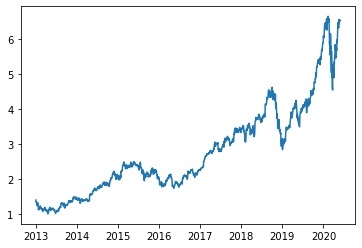

In [ ]:
# date and 14
import matplotlib.pyplot as plt

plt.plot(dfp14['date'], dfp14['14'])

CPU times: user 298 ms, sys: 1.02 ms, total: 299 ms
Wall time: 300 ms


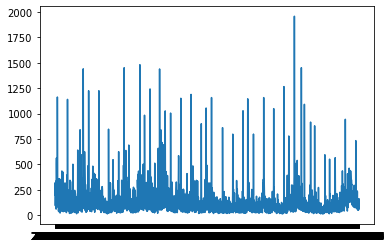

In [ ]:
%%time
plt.plot(dfr14['Date'], dfr14['News'])
# считает быстро, рисует долго

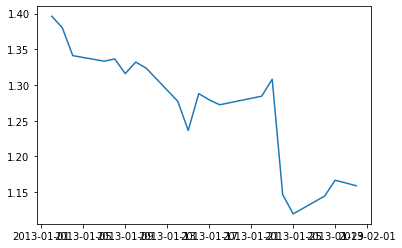

In [ ]:
demo01 = dfp14[(dfp14['year'] == 2013) & (dfp14['month'] < 2)]
plt.plot(demo01['date'], demo01['14'])

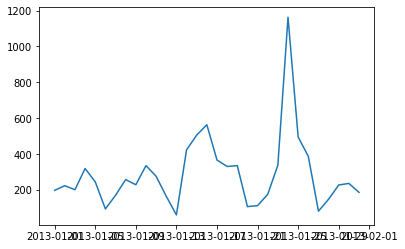

In [ ]:
demo02 = dfr14[(dfr14['Year'] == 2013) & (dfr14['Month'] < 2)]
plt.plot(demo02['Date'], demo02['News'])

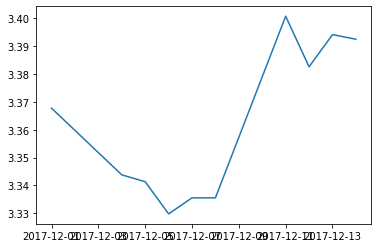

In [ ]:
demo03 = dfp14[(dfp14['year'] == 2017) & (dfp14['month'] > 11) & (dfp14['day'] < 15)]
plt.plot(demo03['date'], demo03['14'])

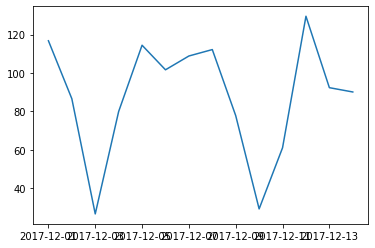

In [ ]:
demo04 = dfr14[(dfr14['Year'] == 2017) & (dfr14['Month'] > 11) & (dfr14['Day'] < 15)]
plt.plot(demo04['Date'], demo04['News'])

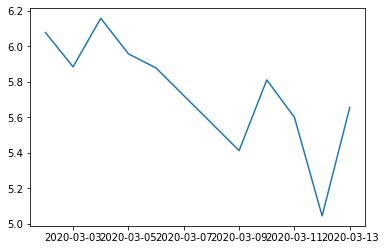

In [ ]:
demo05 = dfp14[(dfp14['year'] == 2020) & (dfp14['month'] == 3) & (dfp14['day'] < 15)]
plt.plot(demo05['date'], demo05['14'])

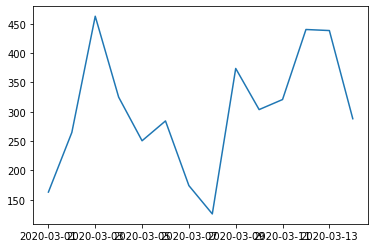

In [ ]:
demo06 = dfr14[(dfr14['Year'] == 2020) & (dfr14['Month'] == 3) & (dfr14['Day'] < 15)]
plt.plot(demo06['Date'], demo06['News'])

## Часть 2.2

### Подготовка модели

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from keras.models import load_model

%matplotlib inline

### ModelX


In [ ]:
shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2])

Epoch 1/60
34/34 [==============================] - 1s 31ms/step - loss: 0.0363 - val_loss: 0.1310
Epoch 2/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0456
Epoch 3/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0146
Epoch 4/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 5/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 6/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 7/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0112
Epoch 8/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0210
Epoch 9/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0114
Epoch 10/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 11/60
34/34 

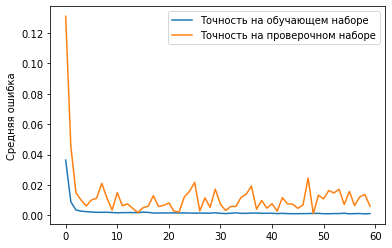

In [ ]:
dataInput = Input(shape)

lstmWay = LSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(100, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)

lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX.fit_generator(trainDataGen,  
                    epochs=60, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

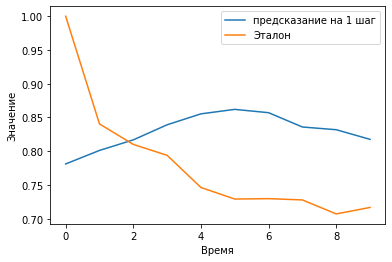

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

### Прогнозируем на несколько шагов вперёд


Для прогноза взял 10 дней

In [ ]:
xLen = 20       
valLen = 100    
stepsForward = 10
trainLen = data.shape[0]-valLen 

xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# создаем дополнительный датасет для у
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,         
                               length=xLen, sampling_rate=1, 
                               batch_size=20)                

#аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 6) (20, 10)


In [ ]:
#генератор проверочной выборки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) 

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Полносвязная сеть**


Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.6780 - val_loss: 1.3386
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.1555
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.1972
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0727 - val_loss: 0.1093
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0654 - val_loss: 0.0934
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0642
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0605
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0806
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0675
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.2403
Epoch 11/

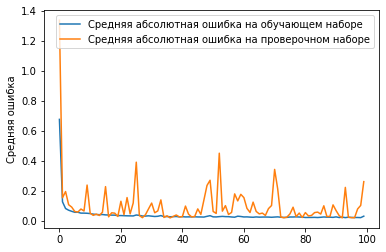

In [ ]:
modelD2 = Sequential()

modelD2.add(Dense(100, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Flatten())
modelD2.add(Dense(yTrain.shape[1], activation="linear"))

modelD2.compile(loss="mse", optimizer=Adam(lr=1e-4))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0236
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0210
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0200
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0236
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0244
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0197
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0239
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0215
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0303
Epoch 11/

**Отображаем результаты**

In [ ]:
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

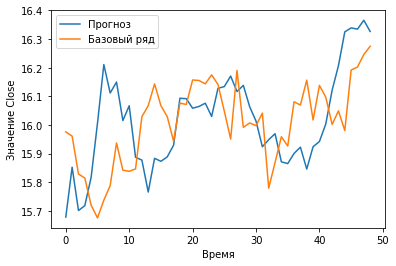

In [ ]:
showPredict(0, 100, 5, predVal2, yValUnscaled2)

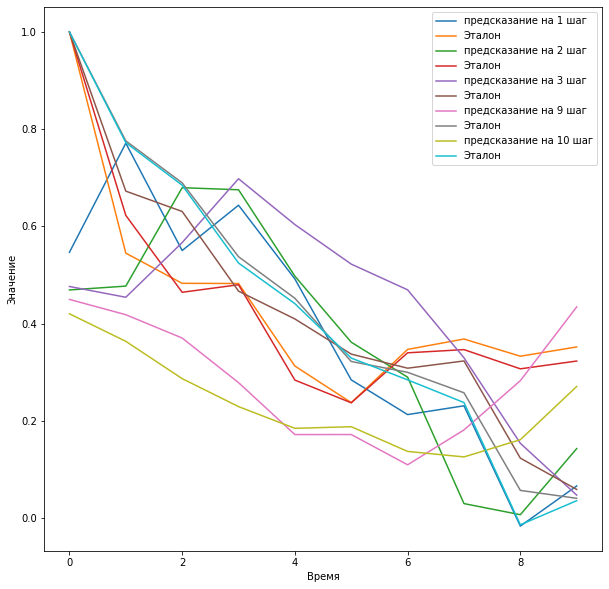

In [ ]:
#Отображаем корреляцию
plt.figure(figsize=(10,10))
showCorr([0, 1, 2, 8, 9], 10, predVal2, yValUnscaled2)

### Предсказание на несколько шагов


### **Предварительные реультаты**

In [ ]:
currModel = modelX3
(predVal3, yValUnscaled3) = getPred(currModel, xVal[0], yVal[0], yScaler)

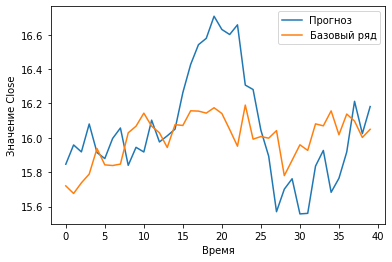

In [ ]:
showPredict(9, 100, 0, predVal3, yValUnscaled3)

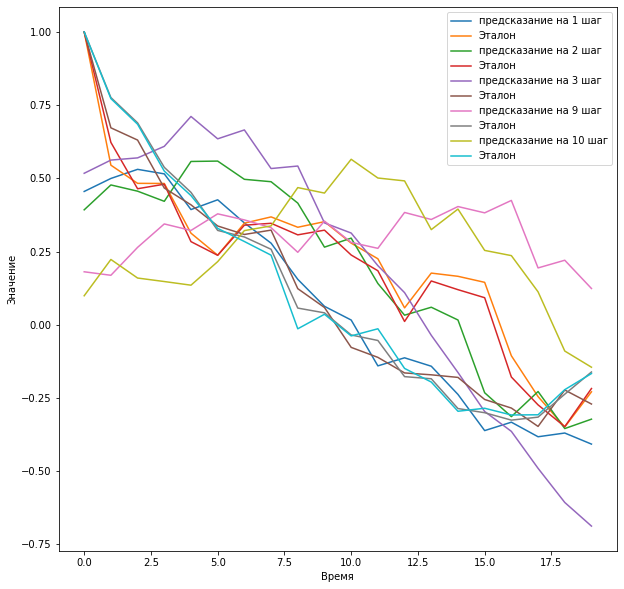

In [ ]:
# корреляция
plt.figure(figsize=(10,10))
showCorr([0, 1, 2, 8, 9], 20, predVal3, yValUnscaled3)